In [19]:
#pip install tensorflow

In [20]:
pip install sktime

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Librerías generales
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time

# Para la evaluacion de datos
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score, mean_absolute_percentage_error
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression
import itertools


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from keras import layers

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.utils.plotting import plot_series

In [23]:
# Ejemplo: guardas todo en /MyDrive/Colab Notebooks/
base_path = "/content/drive/MyDrive/Colab Notebooks"

# Introduccion

Para explicar un poco el contexto de los datos elegidos, se han seleccionado los siguientes datos:

Criptomoneda:
- Datos historicos del Bitcoin desde 17 de Julio del 2010

Índices:
- Datos historicos del SP500 desde el 1 de Enero del 2010
- Datos historicos de la cotización del Oro desde el 1 de Enero del 2010
- Datos historicos del DXY desde el 1 de Enero del 2010

Indicadores técnicos mas usados en el analisis del precio del BTC
- Medias moviles de 50 y 200 periodos
- Medias moviles exponenciales de 14 y 50 periodos
- Convergencia y divergencia de las medias moviles (MACD)
- Fuerza relativa (RSI)

# Cargar los datos del Bitcoin y su estudio

## Cargar datos BTC

In [24]:
# Cargar csv y convertirlo en df
df_btc = pd.read_csv(f"{base_path}/Datos Crypto/Historico_BTC_diario.csv",
                     delimiter = ',', decimal = '.', dtype={'Fecha': str})

#Renombrar la columna
df_btc.rename(columns={ 'close': 'BTC_Close',
                       'date':'Fecha',
                      'open':'BTC_Open','high':'BTC_Max','low':'BTC_Min','volume':'BTC_Vol'}, inplace = True)

# Columnas que deben ser numéricas
cols = ['BTC_Close', 'BTC_Max', 'BTC_Min', 'BTC_Open', 'BTC_Vol']

# Convertir columnas a numérico
for col in cols:
    df_btc[col] = pd.to_numeric(df_btc[col], errors='coerce')

# Redondear valores numéricos a 2 decimales
df_btc = df_btc.round(2)

# Convertir la columna Fecha al tipo datetime
df_btc['Fecha'] = pd.to_datetime(df_btc['Fecha'])

#Ordenar df
df_btc = df_btc.sort_values(by='Fecha', ascending=True).reset_index(drop=True)

df_btc = df_btc.reset_index(drop=True)

# Establecer fecha como indice
df_btc.set_index('Fecha', inplace=True)
df_btc.sort_index(inplace=True, ascending=True)

# Mostrar las primeras filas
df_btc.head()

,BTC_Open,BTC_Max,BTC_Min,BTC_Close,BTC_Vol
Fecha,,,,,
2017-09-01,4689.89,4885.55,4654.88,4834.91,560.67
2017-09-02,4796.16,4939.19,4286.87,4472.14,929.15
2017-09-03,4508.50,4714.76,4298.33,4509.08,691.22
2017-09-04,4505.00,4527.49,3972.51,4100.11,1394.64
2017-09-05,4106.97,4484.99,3603.00,4366.47,1228.94


In [25]:
df_btc.shape

(2860, 5)

In [26]:
df_btc.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2017-09-01 to 2025-06-30
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   BTC_Open   2860 non-null   float64
 1   BTC_Max    2860 non-null   float64
 2   BTC_Min    2860 non-null   float64
 3   BTC_Close  2860 non-null   float64
 4   BTC_Vol    2860 non-null   float64
dtypes: float64(5)
memory usage: 134.1 KB


In [27]:
df_series = df_btc['BTC_Close']
df_series = df_series.asfreq('D')
df_series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 2860 entries, 2017-09-01 to 2025-06-30
Freq: D
Series name: BTC_Close
Non-Null Count  Dtype  
--------------  -----  
2860 non-null   float64
dtypes: float64(1)
memory usage: 44.7 KB


| Columna        | Descripción                                                                                                                                                                                                                                                                                                                                                                                         |
| -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Fecha**      | Representa la fecha específica para la cual se registran los datos del mercado. Cada fila corresponde a un día calendario.                                                                                                                                                                                                                                                                                     |
| **BTC\_Close** | Precio de cierre de Bitcoin (BTC) en dólares estadounidenses (USD) para esa fecha. Es el último precio al que se negociaron BTC en los intercambios al finalizar el día.                                                                                                                                                        |
| **BTC\_Max**   | Precio máximo alcanzado por BTC durante el día. Representa el valor más alto al que se negoció Bitcoin en ese intervalo.                                                                                                                                                                                                                          |
| **BTC\_Min**   | Precio mínimo alcanzado por BTC durante el día. Representa el valor más bajo al que se negoció Bitcoin.                                                                                                                                                                                                                                         |
| **BTC\_Open**  | Precio de apertura de BTC en dólares para ese día. Es el primer precio registrado en los intercambios al comenzar la sesión diaria.                                                                                                                                                                                                       |
| **BTC\_Vol**   | Volumen de Bitcoin negociado en ese día, expresado como la cantidad total de unidades de BTC que se movieron a través de los intercambios durante el periodo. Este valor refleja la liquidez y actividad del mercado, y es un indicador importante para entender la fuerza del movimiento del precio. |

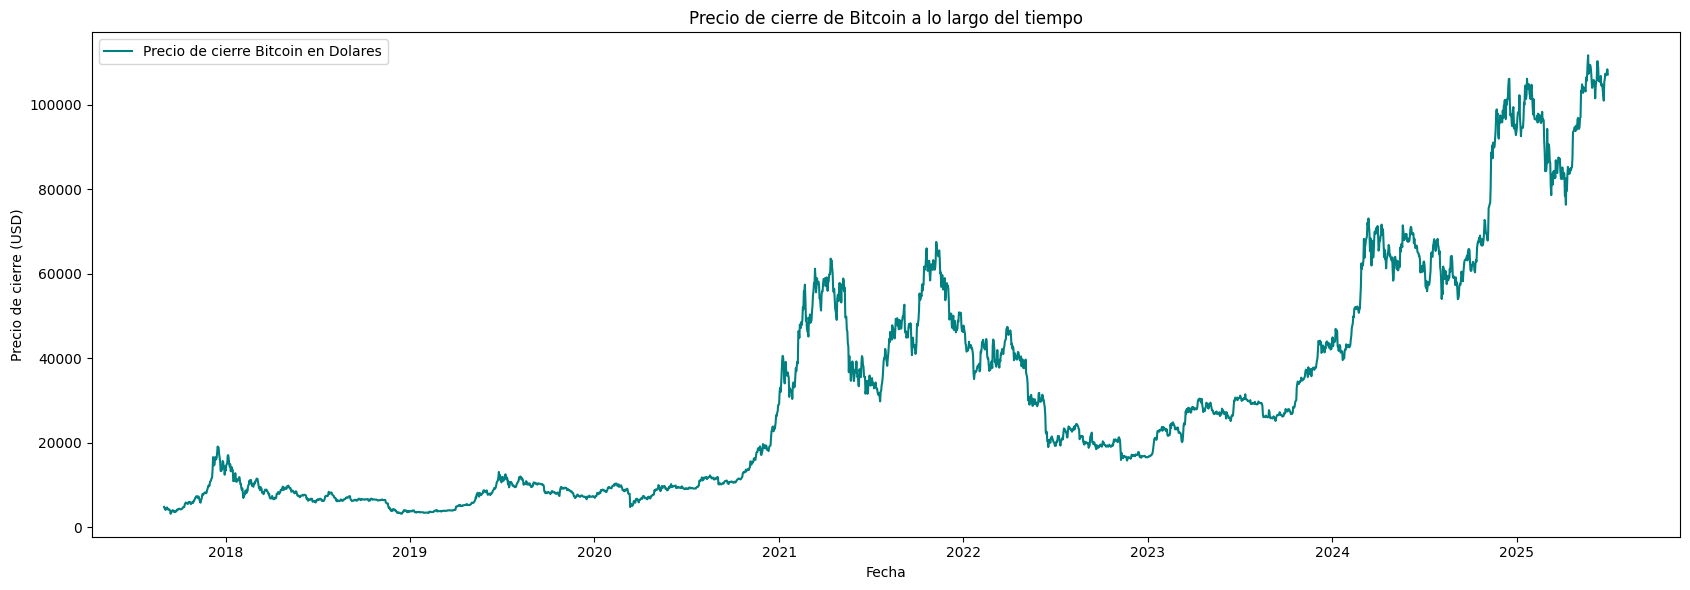

In [28]:
# Gráfico
plt.figure(figsize=(17, 6))
plt.plot(df_btc['BTC_Close'], color='teal', label='Precio de cierre Bitcoin en Dolares')


plt.title('Precio de cierre de Bitcoin a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre (USD)')
plt.legend()
plt.tight_layout()
plt.show()

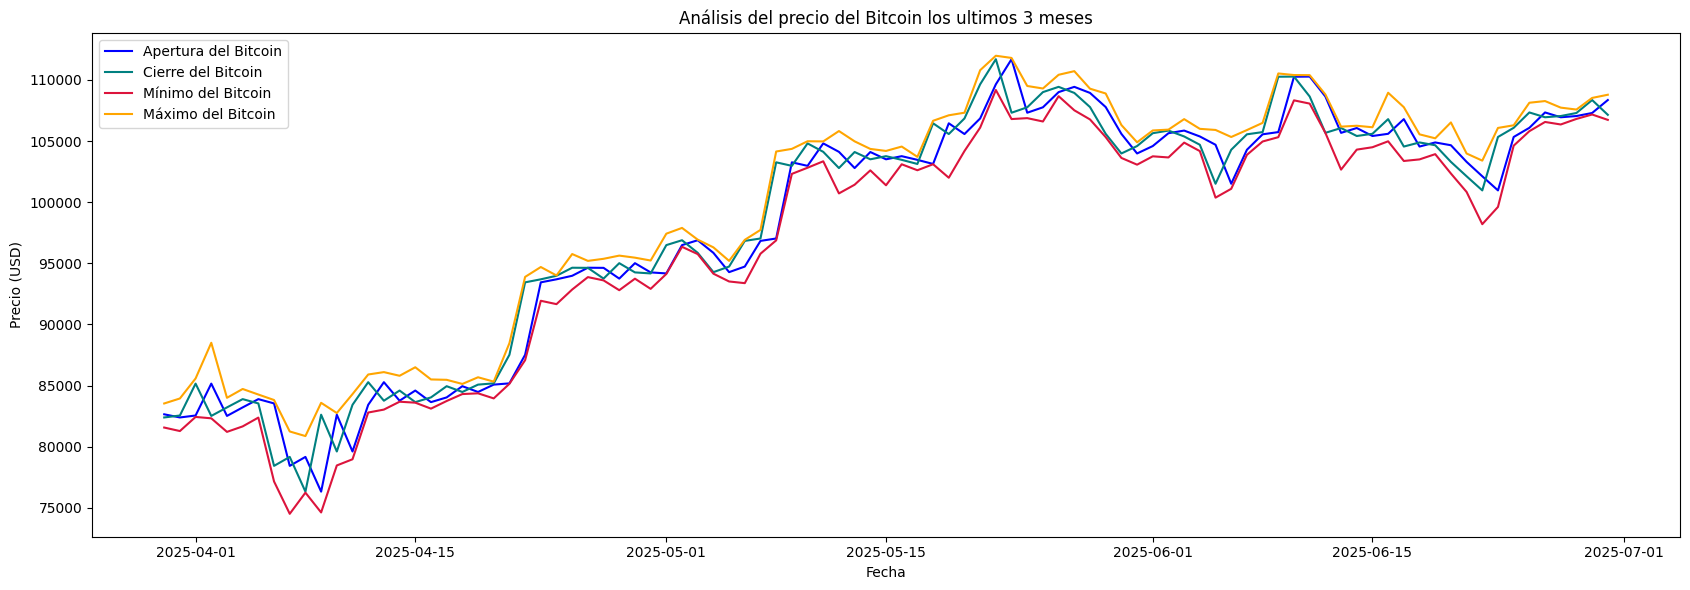

In [29]:
# Fecha máxima en el índice
fecha_max = df_btc.index.max()

# Fecha límite hace 3 meses
fecha_3m = fecha_max - pd.DateOffset(months=3)

# Filtrar últimos 3 meses
df_3mdias = df_btc[df_btc.index >= fecha_3m]

# Gráfico
plt.figure(figsize=(17, 6))
plt.plot(df_3mdias['BTC_Open'], color='blue', label='Apertura del Bitcoin')
plt.plot(df_3mdias['BTC_Close'], color='teal', label='Cierre del Bitcoin')
plt.plot(df_3mdias['BTC_Min'], color='crimson', label='Mínimo del Bitcoin')
plt.plot(df_3mdias['BTC_Max'], color='orange', label='Máximo del Bitcoin')

plt.title('Análisis del precio del Bitcoin los ultimos 3 meses')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.tight_layout()
plt.show()

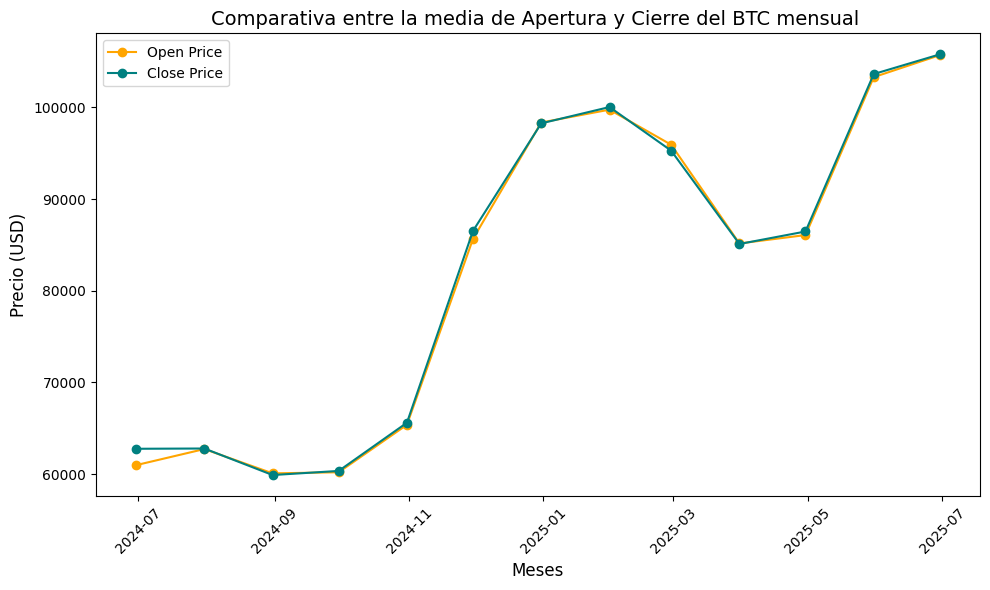

In [30]:
# Fecha límite hace 3 meses
fecha_12m = fecha_max - pd.DateOffset(months=12)

# Filtrar últimos 3 meses
df_12m = df_btc[df_btc.index >= fecha_12m]

df_12mmes = df_12m.resample('ME').mean()

# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(df_12mmes.index, df_12mmes['BTC_Open'], marker='o', color= 'orange', label='Open Price')
plt.plot(df_12mmes.index, df_12mmes['BTC_Close'], marker='o', color= 'teal', label='Close Price')

plt.title('Comparativa entre la media de Apertura y Cierre del BTC mensual ', fontsize=14)
plt.xlabel('Meses', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

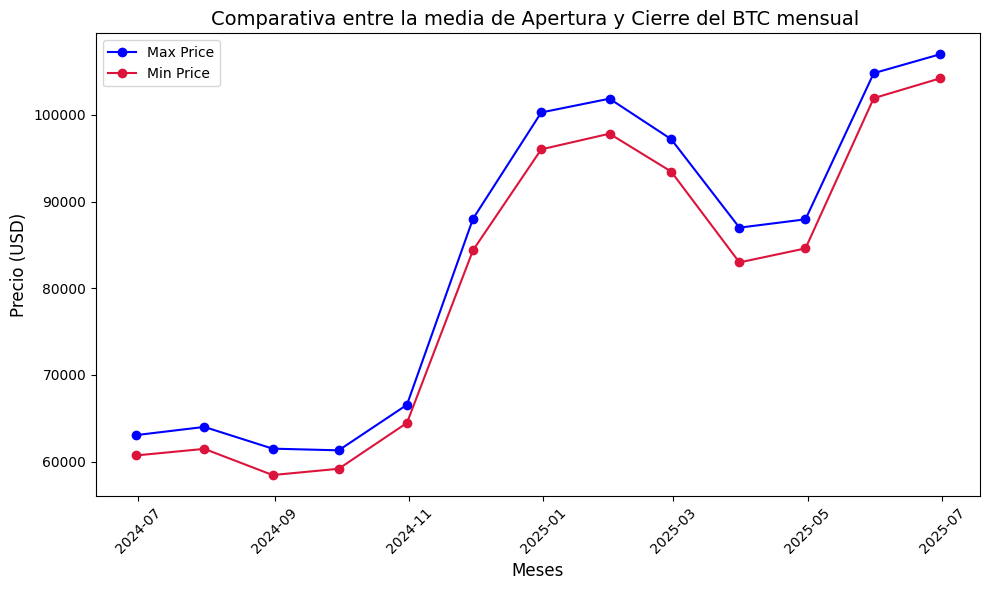

In [31]:
# Gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(df_12mmes.index, df_12mmes['BTC_Max'], marker='o', color= 'blue', label='Max Price')
plt.plot(df_12mmes.index, df_12mmes['BTC_Min'], marker='o', color= 'crimson', label='Min Price')

plt.title('Comparativa entre la media de Apertura y Cierre del BTC mensual ', fontsize=14)
plt.xlabel('Meses', fontsize=12)
plt.ylabel('Precio (USD)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Cargas Datos Blockchain

In [32]:
def cargar_csv_blockchain(nombre_archivo: str) -> pd.DataFrame:
    """
    Carga un CSV de 'data blockchain/', convierte la primera columna en datetime,
    la usa como índice, ordena el índice y elimina la primera columna redundante.

    Parámetros:
        nombre_archivo (str): Nombre del archivo CSV dentro de 'data blockchain/'.

    Retorna:
        pd.DataFrame: DataFrame limpio con el índice temporal.
    """
    ruta = f"{base_path}/data blockchain/{nombre_archivo}.csv"

    df = pd.read_csv(ruta, delimiter=',', decimal='.')

    # convertir primera columna a datetime y renombrar
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
    df.rename(columns={df.columns[0]: "Date"}, inplace=True)

    # poner esa columna como índice
    df.set_index(df.columns[0], inplace=True)
    df.sort_index(inplace=True)

    df.drop(columns=df.columns[0], inplace=True)

    return df

## CCD

In [33]:
df_cdd = cargar_csv_blockchain('cdd_2017-01-01_to_2025-06-30')
df_cdd.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,cdd
Date,
2017-01-01,7631650.82
2017-01-02,16529545.74
2017-01-03,11907939.60
2017-01-04,20949206.12
2017-01-05,47364476.06


## Hashprice

In [34]:
df_hashprice = cargar_csv_blockchain('hashprice_2017-01-01_to_2025-06-30')
df_hashprice.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,hashprice
Date,
2017-01-01,0.816846
2017-01-02,0.849237
2017-01-03,0.866148
2017-01-04,0.987329
2017-01-05,0.844867


## LTH MVRV

In [35]:
df_lth_mvrv = cargar_csv_blockchain('lth-mvrv_2017-01-01_to_2025-06-30')
df_lth_mvrv.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,lthMvrv
Date,
2017-01-01,3.052
2017-01-02,3.170
2017-01-03,3.197
2017-01-04,3.353
2017-01-05,3.272


## LTH SOPR

In [36]:
df_lth_sopr = cargar_csv_blockchain('lth-sopr_2017-01-01_to_2025-06-30')
df_lth_sopr.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,lthSopr
Date,
2017-01-01,2.063023
2017-01-02,2.461140
2017-01-03,2.540780
2017-01-04,1.901861
2017-01-05,2.260301


## MVOCDD

In [37]:
df_mvocdd = cargar_csv_blockchain('mvocdd_2017-01-01_to_2025-06-30')
df_mvocdd.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,mvocdd
Date,
2017-01-01,459.9236
2017-01-02,459.9236
2017-01-03,493.6112
2017-01-04,517.0289
2017-01-05,527.5483


## MVRV

In [38]:
df_mvrv = cargar_csv_blockchain('mvrv_2017-01-01_to_2025-06-30')
df_mvrv.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,mvrv
Date,
2017-01-01,2.348003
2017-01-02,2.382576
2017-01-03,2.405792
2017-01-04,2.613398
2017-01-05,2.295259


## NRPL BTC

In [39]:
df_nrpl = cargar_csv_blockchain('nrpl-btc_2017-01-01_to_2025-06-30')
df_nrpl.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,nrplBtc
Date,
2017-01-01,18883.757934
2017-01-02,20133.623456
2017-01-03,21683.929792
2017-01-04,24345.811955
2017-01-05,35473.086906


## NUPL

In [40]:
df_nupl = cargar_csv_blockchain('nupl_2017-01-01_to_2025-06-30')
df_nupl.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,nupl
Date,
2017-01-01,0.5656
2017-01-02,0.5718
2017-01-03,0.5759
2017-01-04,0.6090
2017-01-05,0.5530


## Puell Multiple

In [41]:
df_puell = cargar_csv_blockchain('puell-multiple_2017-01-01_to_2025-06-30')
df_puell.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,puellMultiple
Date,
2017-01-01,1.324
2017-01-02,1.387
2017-01-03,1.420
2017-01-04,1.145
2017-01-05,1.175


## Realized loss LTH

In [42]:
df_loss_lth = cargar_csv_blockchain('realized_loss_lth_2017-01-01_to_2025-06-30')
df_loss_lth.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,realizedLossLth
Date,
2017-01-01,-32.996081
2017-01-02,-33.762194
2017-01-03,-31.735008
2017-01-04,-28.817452
2017-01-05,-25.989930


## Realized profit LTH

In [43]:
df_profit_lth = cargar_csv_blockchain('realized_profit_lth_2017-01-01_to_2025-06-30')
df_profit_lth.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,realizedProfitLth
Date,
2017-01-01,8703.773924
2017-01-02,9231.548559
2017-01-03,9273.311930
2017-01-04,10234.038996
2017-01-05,19034.227464


## Realized profit STH

In [44]:
df_profit_sth = cargar_csv_blockchain('realized_profit_sth_2017-01-01_to_2025-06-30')
df_profit_sth.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,realizedProfitSth
Date,
2017-01-01,10245.976172
2017-01-02,10969.599284
2017-01-03,12474.087877
2017-01-04,14169.407863
2017-01-05,16490.839303


## SOPR

In [45]:
df_sopr = cargar_csv_blockchain('sopr_2017-01-01_to_2025-06-30')
df_sopr.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,sopr
Date,
2017-01-01,1.021277
2017-01-02,1.023964
2017-01-03,1.017764
2017-01-04,1.028720
2017-01-05,1.026585


## STH MVRV

In [46]:
df_sth_mvrv = cargar_csv_blockchain('sth-mvrv_2017-01-01_to_2025-06-30')
df_sth_mvrv.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,sthMvrv
Date,
2017-01-01,1.292
2017-01-02,1.329
2017-01-03,1.328
2017-01-04,1.365
2017-01-05,1.311


## STH SOPR

In [47]:
df_sth_sopr = cargar_csv_blockchain('sth-sopr_2017-01-01_to_2025-06-30')
df_sth_sopr.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,sthSopr
Date,
2017-01-01,1.041915
2017-01-02,1.069621
2017-01-03,1.080865
2017-01-04,1.086621
2017-01-05,1.075128


## Thermo price

In [48]:
df_thermo_price = cargar_csv_blockchain('thermo-price_2017-01-01_to_2025-06-30')
df_thermo_price.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,thermoPrice
Date,
2017-01-01,152.701469
2017-01-02,159.027057
2017-01-03,159.136811
2017-01-04,159.246462
2017-01-05,159.343030


## True Market Mean

In [49]:
df_true_market = cargar_csv_blockchain('true-market-mean_2017-01-01_to_2025-06-30')
df_true_market.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,trueMarketMean
Date,
2017-01-01,648.3660
2017-01-02,653.0503
2017-01-03,663.9118
2017-01-04,669.4429
2017-01-05,665.8703


## Value days destroyed

In [50]:
df_vdd = cargar_csv_blockchain('value-days-destroyed_2017-01-01_to_2025-06-30')
df_vdd.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,valueDaysDestroyed
Date,
2017-01-01,1.4947
2017-01-02,1.5384
2017-01-03,1.6070
2017-01-04,1.7874
2017-01-05,1.8452


## VOCDD

In [51]:
df_vocdd = cargar_csv_blockchain('vocdd_2017-01-01_to_2025-06-30')
df_vocdd.head()

/usr/local/lib/python3.12/dist-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


,vocdd
Date,
2017-01-01,473.3814
2017-01-02,1045.5551
2017-01-03,764.6258
2017-01-04,1477.7313
2017-01-05,2946.0936


# Unir df

In [52]:
df_unido = df_btc.copy()

for df in [df_cdd,df_lth_mvrv,df_hashprice,
           df_lth_sopr, df_mvocdd, df_mvrv,
           df_nrpl, df_nupl, df_puell, df_loss_lth, df_profit_lth,
           df_profit_sth,  df_sopr, df_sth_mvrv, df_sth_sopr,
           df_thermo_price, df_true_market, df_vdd, df_vocdd]:

    df_unido = df_unido.merge(df, left_index=True, right_index=True, how='left')

In [53]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2017-09-01 to 2025-06-30
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_Open            2860 non-null   float64
 1   BTC_Max             2860 non-null   float64
 2   BTC_Min             2860 non-null   float64
 3   BTC_Close           2860 non-null   float64
 4   BTC_Vol             2860 non-null   float64
 5   cdd                 2857 non-null   float64
 6   lthMvrv             2860 non-null   float64
 7   hashprice           2860 non-null   float64
 8   lthSopr             2857 non-null   float64
 9   mvocdd              2860 non-null   float64
 10  mvrv                2860 non-null   float64
 11  nrplBtc             2859 non-null   float64
 12  nupl                2859 non-null   float64
 13  puellMultiple       2860 non-null   float64
 14  realizedLossLth     2859 non-null   float64
 15  realizedProfitLth   2859 non-null   f

In [54]:
df_unido_ffill = df_unido.ffill()

In [55]:
df_unido_ffill.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2017-09-01 to 2025-06-30
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_Open            2860 non-null   float64
 1   BTC_Max             2860 non-null   float64
 2   BTC_Min             2860 non-null   float64
 3   BTC_Close           2860 non-null   float64
 4   BTC_Vol             2860 non-null   float64
 5   cdd                 2860 non-null   float64
 6   lthMvrv             2860 non-null   float64
 7   hashprice           2860 non-null   float64
 8   lthSopr             2860 non-null   float64
 9   mvocdd              2860 non-null   float64
 10  mvrv                2860 non-null   float64
 11  nrplBtc             2860 non-null   float64
 12  nupl                2860 non-null   float64
 13  puellMultiple       2860 non-null   float64
 14  realizedLossLth     2860 non-null   float64
 15  realizedProfitLth   2860 non-null   f

In [56]:
df_unido_ffill.drop(columns=['BTC_Max', 'BTC_Min', 'BTC_Open'], inplace=True)

In [57]:
df_modelo = df_unido_ffill
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2860 entries, 2017-09-01 to 2025-06-30
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   BTC_Close           2860 non-null   float64
 1   BTC_Vol             2860 non-null   float64
 2   cdd                 2860 non-null   float64
 3   lthMvrv             2860 non-null   float64
 4   hashprice           2860 non-null   float64
 5   lthSopr             2860 non-null   float64
 6   mvocdd              2860 non-null   float64
 7   mvrv                2860 non-null   float64
 8   nrplBtc             2860 non-null   float64
 9   nupl                2860 non-null   float64
 10  puellMultiple       2860 non-null   float64
 11  realizedLossLth     2860 non-null   float64
 12  realizedProfitLth   2860 non-null   float64
 13  realizedProfitSth   2860 non-null   float64
 14  sopr                2860 non-null   float64
 15  sthMvrv             2860 non-null   f

In [58]:
df_modelo.head()

,BTC_Close,BTC_Vol,cdd,lthMvrv,hashprice,lthSopr,mvocdd,mvrv,nrplBtc,nupl,...,realizedLossLth,realizedProfitLth,realizedProfitSth,sopr,sthMvrv,sthSopr,thermoPrice,trueMarketMean,valueDaysDestroyed,vocdd
Fecha,,,,,,,,,,,,,,,,,,,,,
2017-09-01,4834.91,560.67,18059558.73,13.156,1.628744,5.836943,5707.9410,3.238962,47599.761751,0.6818,...,-1.000000e-06,20685.864733,26913.897020,1.036003,1.479,1.101722,207.471779,2539.2469,2.8067,5370.5824
2017-09-02,4472.14,929.15,13638788.72,12.765,1.489479,6.626187,5529.8628,3.010218,47396.800898,0.6575,...,-8.000000e-07,20493.534195,26903.266705,1.023035,1.427,1.109098,208.027296,2551.6042,2.5906,3788.9635
2017-09-03,4509.08,691.22,14658214.06,12.532,1.470106,8.679242,5447.8510,3.014736,45286.188150,0.6581,...,-7.000000e-07,19443.413279,25842.774873,1.017558,1.397,1.074111,208.533921,2564.5438,2.4761,4098.5222
2017-09-04,4100.11,1394.64,18699633.03,11.947,1.422845,7.216707,5338.2211,2.838324,46934.939827,0.6366,...,-6.000000e-07,19606.527536,27328.412292,1.013659,1.327,1.088722,209.083790,2577.5394,2.3239,4944.6541
2017-09-05,4366.47,1228.94,12063157.48,11.650,1.405426,6.808303,5125.2569,2.874407,45342.257371,0.6412,...,-6.000000e-07,18330.376586,27011.880786,1.003472,1.291,1.045368,209.687843,2597.6060,2.2714,3247.1395


# Estudio de variables

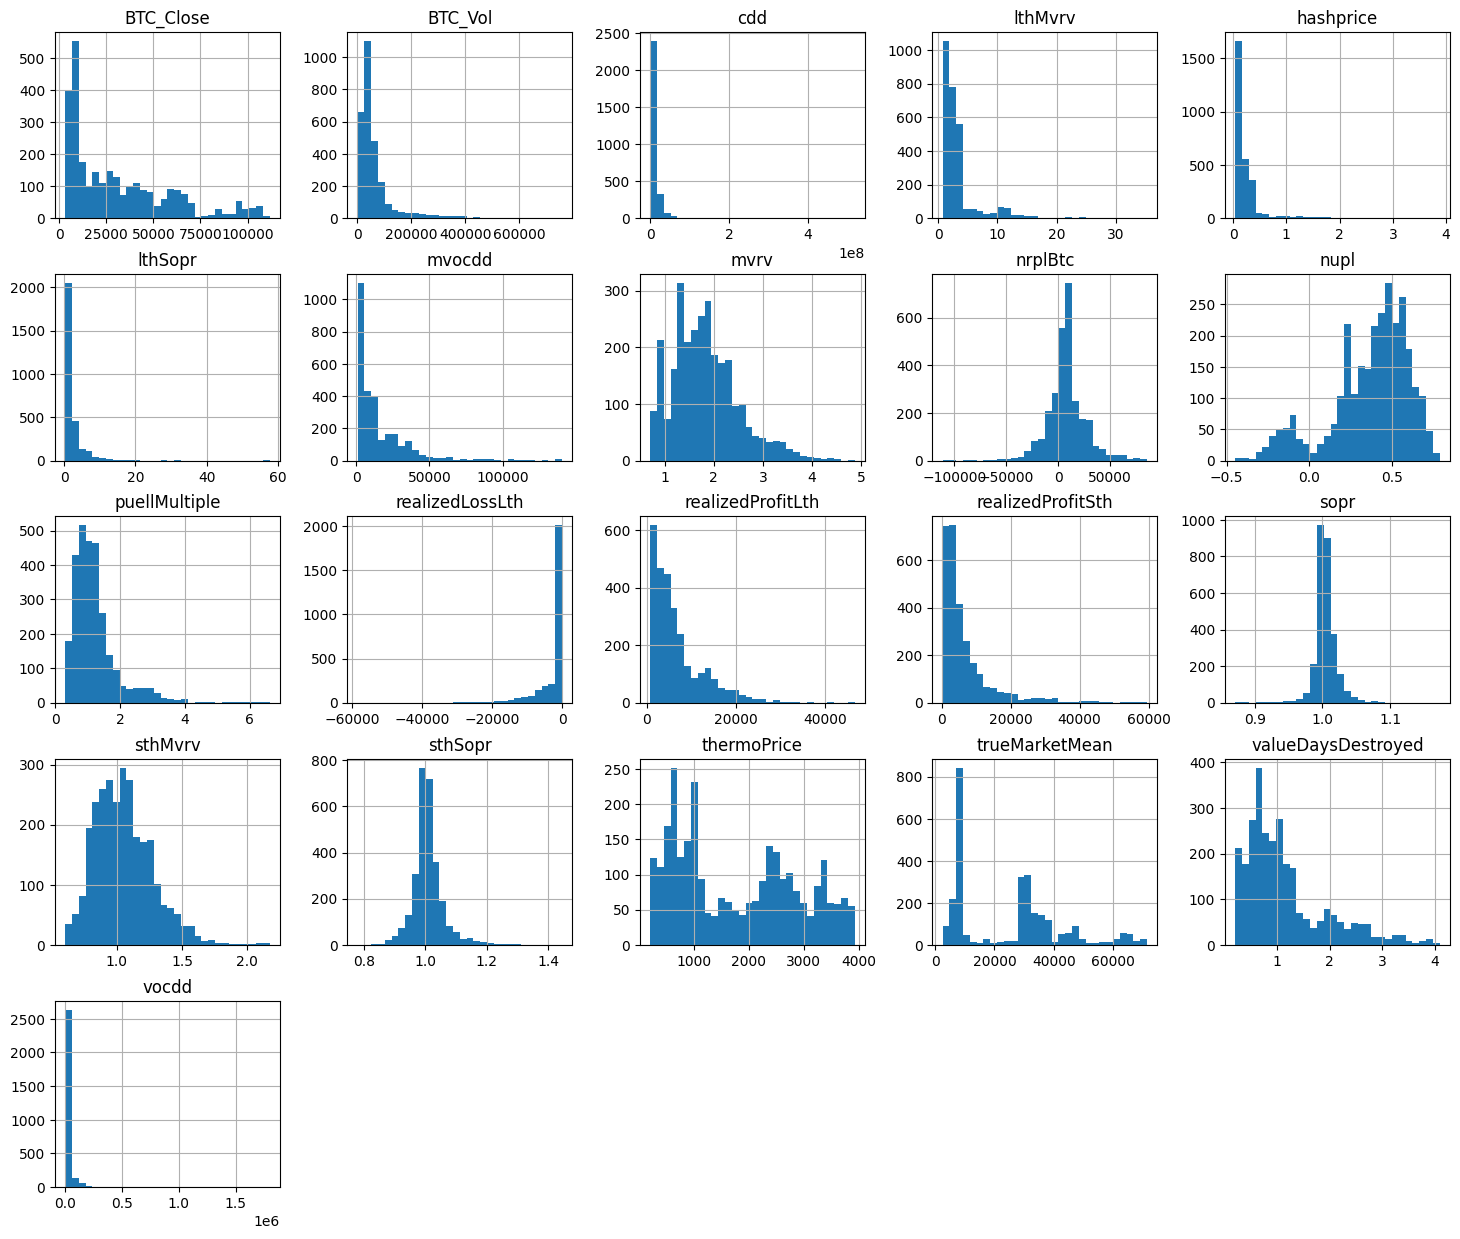

In [59]:
# Distrubcion de las variables
df_modelo.hist(bins=30, figsize=(18,15))
plt.show()

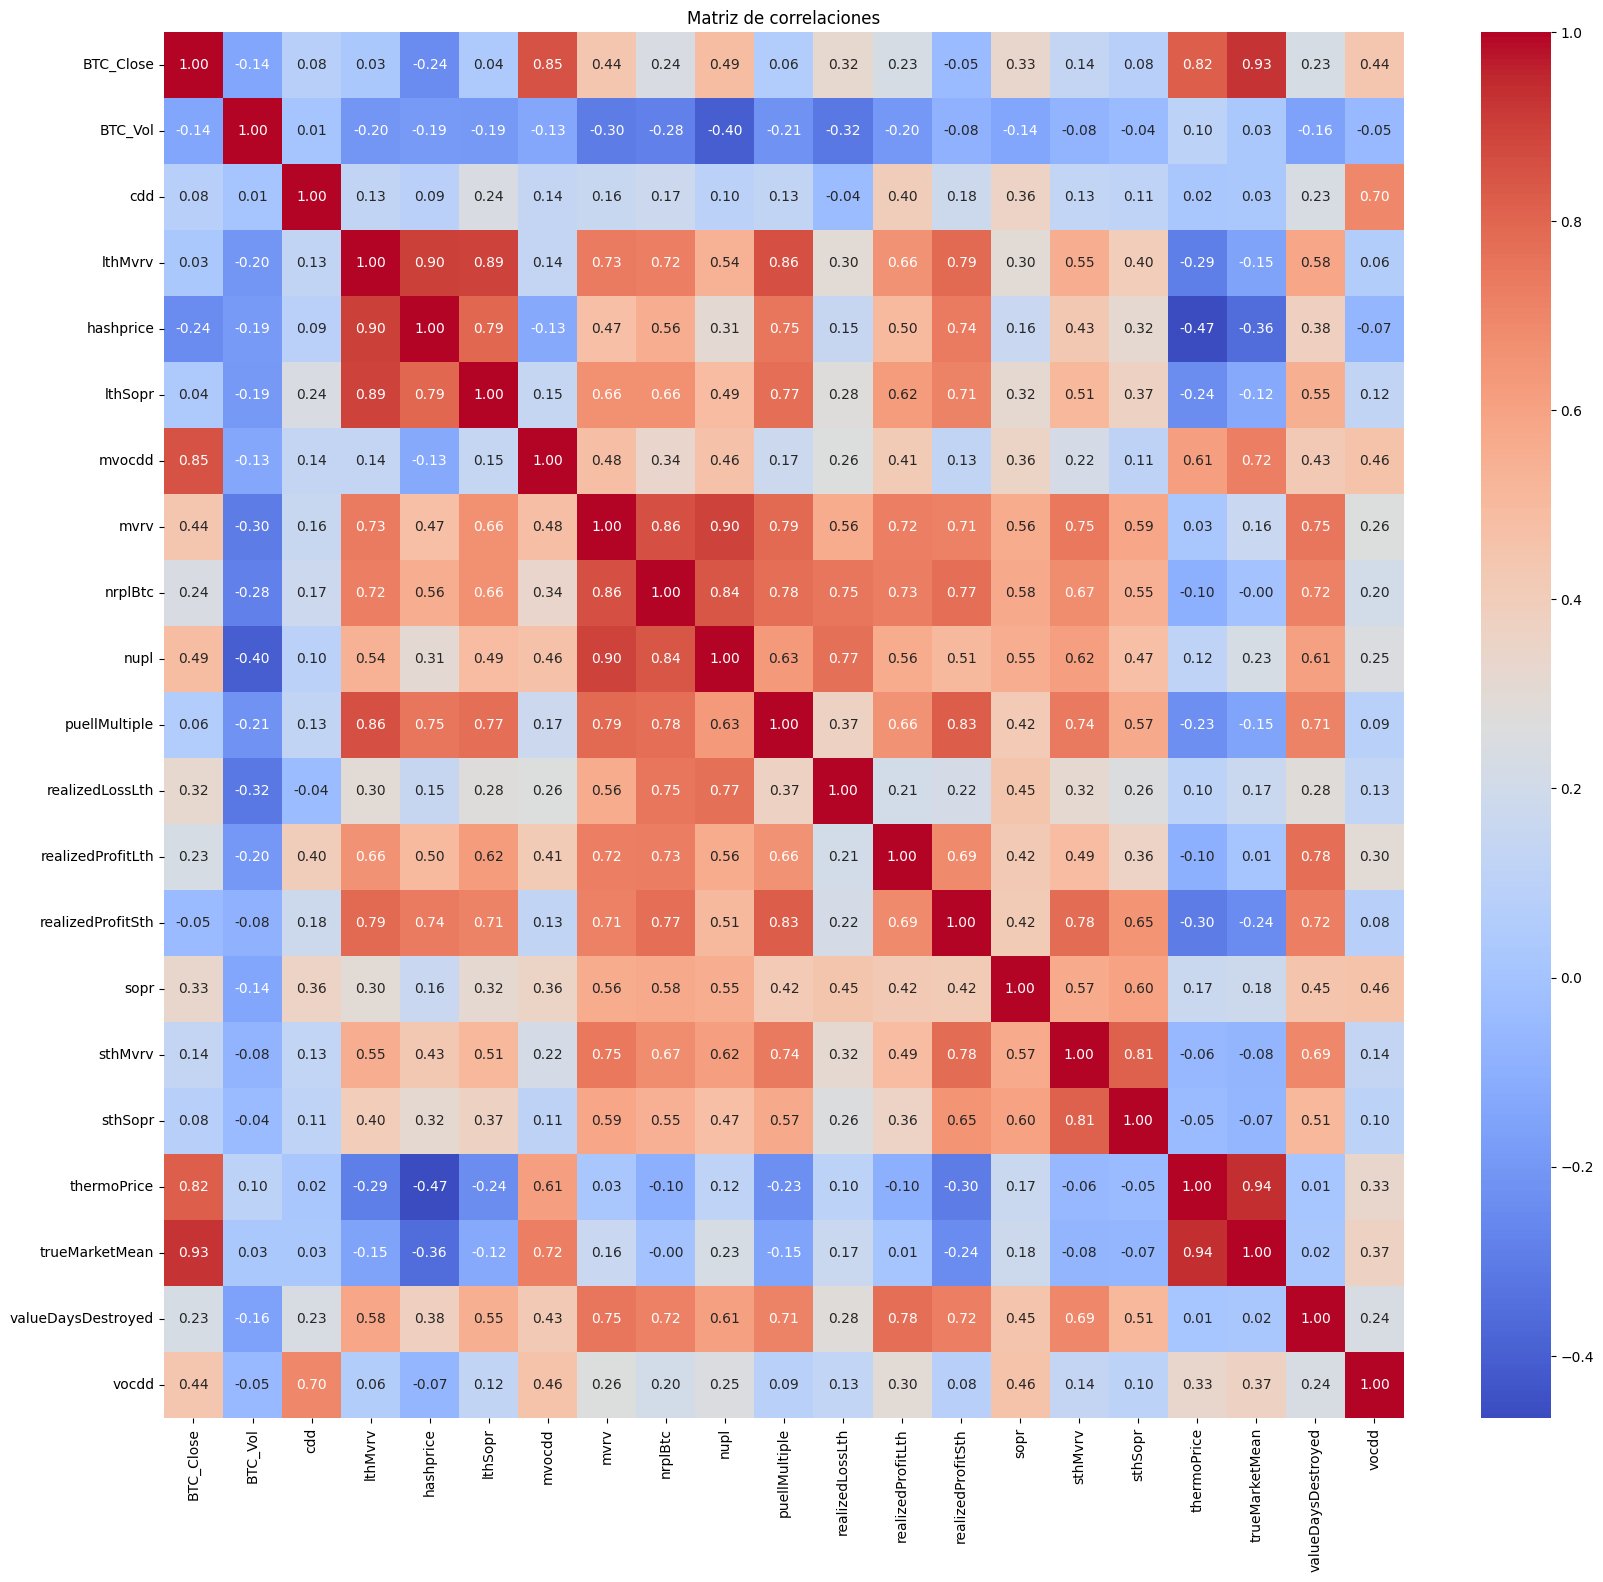

In [60]:
# Mapa de correlacion
plt.figure(figsize=(20,18))
sns.heatmap(df_modelo.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de correlaciones")
plt.show()

In [61]:
# Eliminar las variables con una alta correlacion entre ellas para no sea redundante
def eliminar_var_alta_corr(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    drop_cols = [col for col in upper.columns if any(upper[col] > threshold)]

    # Sobrescribir el DataFrame original
    df.drop(columns=drop_cols, inplace=True)
    return drop_cols

# Aplicar al DataFrame
eliminadas = eliminar_var_alta_corr(df_modelo, threshold=0.9)

print("Columnas eliminadas por alta correlación:", eliminadas)
print("Nuevo shape de df_modelo:", df_modelo.shape)

Columnas eliminadas por alta correlación: ['trueMarketMean']
Nuevo shape de df_modelo: (2860, 20)


In [62]:
# Calcular correlaciones con la variable target
corr_target = df_modelo.corr()['BTC_Close'].sort_values(ascending=False)

# Mostrar listado
print(corr_target)

BTC_Close             1.000000
mvocdd                0.851990
thermoPrice           0.820454
nupl                  0.485754
mvrv                  0.443607
vocdd                 0.443538
sopr                  0.330730
realizedLossLth       0.324100
nrplBtc               0.242544
realizedProfitLth     0.229811
valueDaysDestroyed    0.227711
sthMvrv               0.137987
cdd                   0.080035
sthSopr               0.079567
puellMultiple         0.056343
lthSopr               0.041638
lthMvrv               0.027729
realizedProfitSth    -0.046727
BTC_Vol              -0.141584
hashprice            -0.243209
Name: BTC_Close, dtype: float64


In [63]:
# Variables a eliminar según correlación con BTC_Close
irrelevantes = df_modelo.columns[(df_modelo.corr()['BTC_Close'] >= -0.2) &
                                 (df_modelo.corr()['BTC_Close'] <= 0.2)].tolist()

df_modelo = df_modelo.drop(columns=irrelevantes)
print("Variables eliminadas por baja correlación:", irrelevantes)

Variables eliminadas por baja correlación: ['BTC_Vol', 'cdd', 'lthMvrv', 'lthSopr', 'puellMultiple', 'realizedProfitSth', 'sthMvrv', 'sthSopr']


**La información mutua (IM)** entre dos variables aleatorias es un valor no negativo que mide la dependencia entre las variables. Es igual a cero si y sólo si dos variables aleatorias son independientes, y los valores más altos significan una mayor dependencia

In [64]:
# Informacion mutua
X = df_modelo.drop(columns=['BTC_Close'])
y = df_modelo['BTC_Close']

mi = mutual_info_regression(X, y)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print(mi_series)

thermoPrice           3.089145
mvrv                  2.117002
nupl                  2.053715
hashprice             1.843855
mvocdd                1.779373
valueDaysDestroyed    1.084553
nrplBtc               0.953312
realizedLossLth       0.950978
vocdd                 0.588465
realizedProfitLth     0.585401
sopr                  0.293277
dtype: float64


In [65]:
# Umbral
umbral = 0.5

# Variables a mantener
vars_importantes = mi_series[mi_series >= umbral].index

# Filtrar df_modelo
df_modelo = df_modelo[vars_importantes.tolist() + ['BTC_Close']]

print("Variables conservadas:", list(df_modelo.columns))

Variables conservadas: ['thermoPrice', 'mvrv', 'nupl', 'hashprice', 'mvocdd', 'valueDaysDestroyed', 'nrplBtc', 'realizedLossLth', 'vocdd', 'realizedProfitLth', 'BTC_Close']


La información mutua mide la dependencia entre dos variables, capturando tanto relaciones lineales como no lineales. En este caso, la MI entre cada variable explicativa (X) y el precio de Bitcoin (BTC_Close). Valores más altos indican mayor dependencia informativa; es decir, esa variable aporta más conocimiento sobre el comportamiento de BTC, MI siempre es no negativa ($𝑀𝐼≥0$), y su magnitud depende de la entropía de las variables.

No existe un umbral de referencia aunque algunos estudios recomiendan normalizar para obtener los valores dentro de una escala para poder compararlas

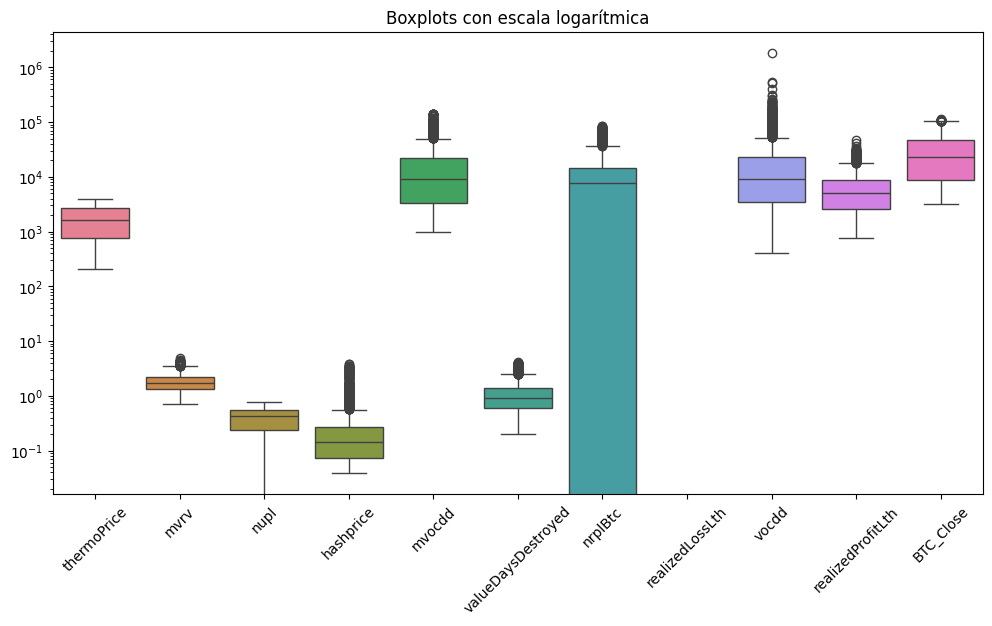

In [66]:
# Visualizacion de los outliers de forma logaritmica
num_cols = df_modelo.select_dtypes(include='number').columns

plt.figure(figsize=(12,6))
sns.boxplot(data=df_modelo[num_cols])
plt.yscale('log')  # escala logarítmica para ver mejor las diferencias
plt.xticks(rotation=45)
plt.title('Boxplots con escala logarítmica')
plt.show()

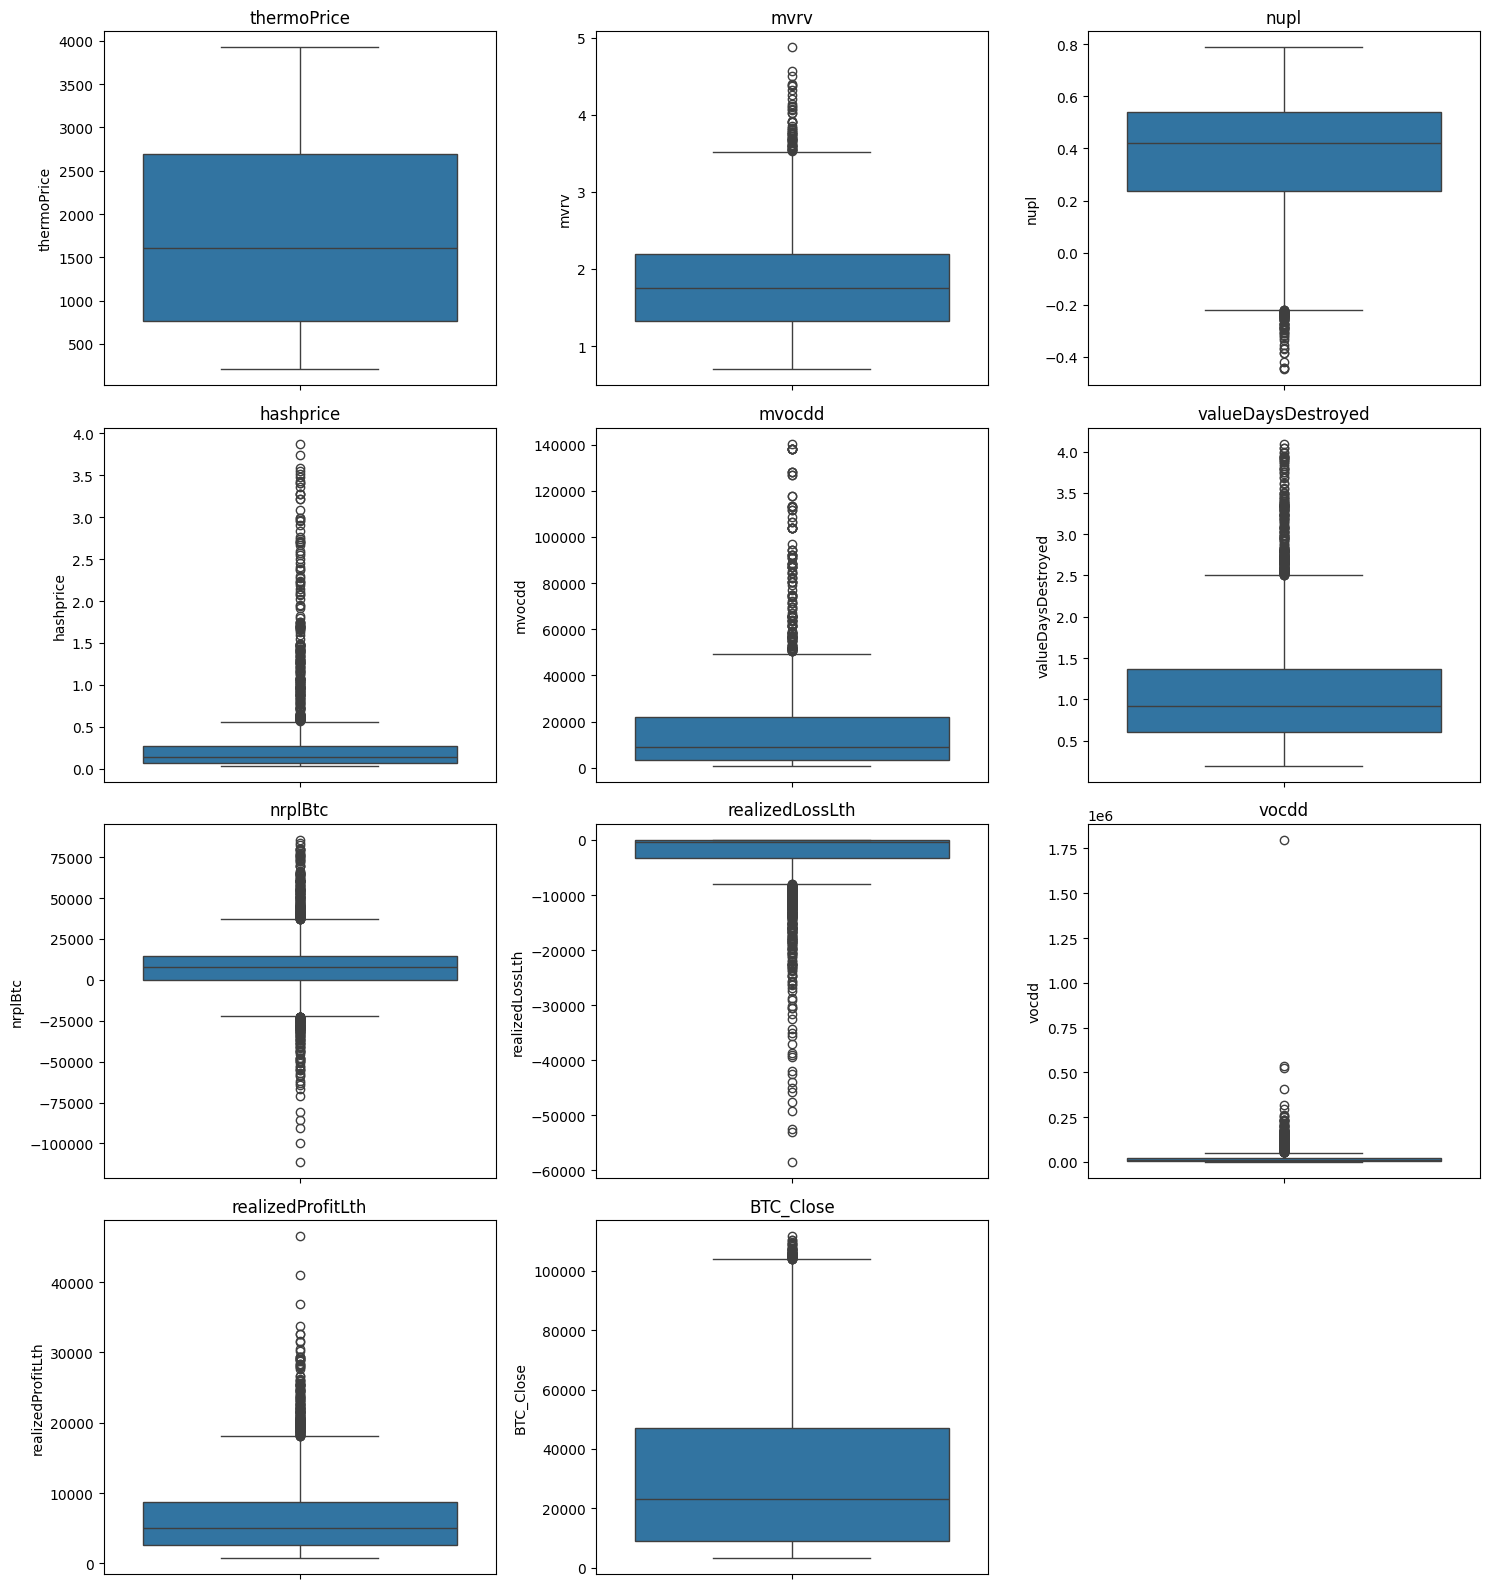

In [67]:
num_cols = df_modelo.select_dtypes(include='number').columns
n_cols = 3  # columnas por fila
n_rows = int(np.ceil(len(num_cols)/n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows*4))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(y=df_modelo[col], ax=axes[i])
    axes[i].set_title(col)

# Limpiar ejes vacíos si hay subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Seleccion de Variables

## Semilla de reproducibilidad

In [68]:
# Establecer semilla
SEED = 42

## Variables seleccionadas y Estandarizacion

In [69]:
# Variables seleccionadas
variables = ['thermoPrice', 'mvrv', 'nupl', 'hashprice', 'mvocdd', 'valueDaysDestroyed',
             'nrplBtc', 'realizedLossLth', 'vocdd', 'realizedProfitLth']

target = "BTC_Close"

## Test y train y Crear secuencias

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps, 0])  # y debe ser (n,1)
    return np.array(Xs), np.array(ys)

X = df_modelo[variables]
y = df_modelo[[target]]   # 👈 aseguramos que sea DataFrame (n,1)

# Separar train/val (95%) y test (5%)
n_total = len(X)
n_test = int(n_total * 0.1)
n_trainval = n_total - n_test

X_trainval_raw = X.iloc[:n_trainval]
y_trainval_raw = y.iloc[:n_trainval]

X_test_raw = X.iloc[n_trainval:]
y_test_raw = y.iloc[n_trainval:]

# Rolling window solo sobre el 90% inicial
tscv = TimeSeriesSplit(n_splits=5, test_size=120)

time_steps = [3, 6, 9]
all_sequences = {}

for split, (train_idx, val_idx) in enumerate(tscv.split(X_trainval_raw)):
    # Datos crudos
    X_train_raw, X_val_raw = X_trainval_raw.iloc[train_idx], X_trainval_raw.iloc[val_idx]
    y_train_raw, y_val_raw = y_trainval_raw.iloc[train_idx], y_trainval_raw.iloc[val_idx]

    # Escaladores independientes por split
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train = scaler_X.fit_transform(X_train_raw)
    X_val   = scaler_X.transform(X_val_raw)
    y_train = scaler_y.fit_transform(y_train_raw)
    y_val   = scaler_y.transform(y_val_raw)

    # Crear secuencias para cada time_step
    split_sequences = {}
    for t in time_steps:
        X_train_seq, y_train_seq = create_sequences(X_train, y_train, t)
        X_val_seq, y_val_seq     = create_sequences(X_val, y_val, t)

        split_sequences[t] = {
            "X_train": X_train_seq,
            "y_train": y_train_seq,
            "X_val": X_val_seq,
            "y_val": y_val_seq,
            "scaler_X": scaler_X,
            "scaler_y": scaler_y
        }

    all_sequences[split] = split_sequences

# Crear secuencias de test (con scaler del último split)
last_split = max(all_sequences.keys())
last_scaler_X = all_sequences[last_split][time_steps[0]]["scaler_X"]
last_scaler_y = all_sequences[last_split][time_steps[0]]["scaler_y"]

X_test = last_scaler_X.transform(X_test_raw)
y_test = last_scaler_y.transform(y_test_raw)

test_sequences = {}
for t in time_steps:
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, t)
    test_sequences[t] = {
        "X_test": X_test_seq,
        "y_test": y_test_seq
    }

print("Rolling window sobre 90% guardado en all_sequences[split][time_step]")
print("Test final (10% últimos datos) guardado en test_sequences[time_step]")

Rolling window sobre 90% guardado en all_sequences[split][time_step]
Test final (10% últimos datos) guardado en test_sequences[time_step]


## Hiperparametros a valorar

In [71]:
# Hiperparámetros a probar
num_layers_list = [1, 2]                     # número de capas
units_list = [32, 64]                        # neuronas por capa
activations_list = ["elu", "relu", "selu"]   # funciones de activación
learning_rates = [0.1, 0.01, 0.001]          # tasas de aprendizaje
optimizers_list = ["adam", "rmsprop"]        # optimizadores
batch_sizes = [32, 64, 128]                  # tamaños de batch
epochs = 10                                  # número de épocas

## Establecer un Early Stopping para despues optimizar los resultados

In [72]:
# EarlyStopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Estudio RNN nuevo

## Busqueda Hiperparametros

In [ ]:
# Semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
time_steps = [9]
for time in time_steps:
    resultados = []

    # Recorremos todas las combinaciones de hiperparámetros
    for num_layers in num_layers_list:
        for units in units_list:
            for activation in activations_list:
                for lr in learning_rates:
                    for opt_name in optimizers_list:
                        for batch in batch_sizes:
                            print(f"Entrenando: capas={num_layers}, units={units}, act={activation}, lr={lr}, opt={opt_name}, batch={batch}, time_step={time}")

                            # Métricas acumuladas en los splits
                            maes, rmses, mapes, r2s = [], [], [], []

                            # Backtesting: iterar sobre splits
                            for split in all_sequences.keys():
                                data = all_sequences[split][time]

                                X_train_seq = data["X_train"]
                                y_train_seq = data["y_train"]
                                X_val_seq = data["X_val"]
                                y_val_seq = data["y_val"]

                                # Crear modelo RNN
                                model = keras.Sequential()
                                for i in range(num_layers):
                                    model.add(layers.SimpleRNN(
                                        units,
                                        activation=activation,
                                        return_sequences=(i < num_layers - 1)
                                    ))
                                model.add(layers.Dense(1, activation="linear"))

                                # Optimizador
                                if opt_name == "adam":
                                    optimizer = keras.optimizers.Adam(learning_rate=lr)
                                elif opt_name == "rmsprop":
                                    optimizer = keras.optimizers.RMSprop(learning_rate=lr)

                                model.compile(optimizer=optimizer, loss="mse")

                                # Entrenar
                                model.fit(
                                    X_train_seq, y_train_seq,
                                    validation_data=(X_val_seq, y_val_seq),
                                    epochs=epochs, batch_size=batch, verbose=0
                                )

                                # Predicciones
                                y_val_pred = model.predict(X_val_seq, verbose=0)

                                # Métricas
                                mae = mean_absolute_error(y_val_seq, y_val_pred)
                                rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
                                mape = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100
                                r2 = r2_score(y_val_seq, y_val_pred)

                                maes.append(mae)
                                rmses.append(rmse)
                                mapes.append(mape)
                                r2s.append(r2)

                            # Promedio sobre los splits
                            resultados.append({
                                "time_step": time,
                                "capas": num_layers,
                                "units": units,
                                "activation": activation,
                                "lr": lr,
                                "opt": opt_name,
                                "batch": batch,
                                "MAE": np.mean(maes),
                                "RMSE": np.mean(rmses),
                                "MAPE": np.mean(mapes),
                                "R2": np.mean(r2s),
                            })

    # Guardar resultados de este time_step
    df_resultados_rnn = pd.DataFrame(resultados)
    df_resultados_rnn = df_resultados_rnn.sort_values("MAPE", ascending=True)
    df_resultados_rnn.to_csv(f"resultados_rnn_backtesting_time{time}_epoch 10.csv", index=False)
    print(f"Guardado resultados para time_step={time}")

Entrenando: capas=1, units=32, act=elu, lr=0.1, opt=adam, batch=32, time_step=9


## Optimizar los modelos con los mejores parametros

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

time_steps = [3, 6, 9]

for time in time_steps:
    # Cargar top-5 modelos del CSV inicial
    top_rnn_models_df = pd.read_csv(f"resultados_rnn_backtesting_time{time}_epoch 10.csv")
    top_rnn_models_df = top_rnn_models_df.sort_values("MAE", ascending=True).head(5)

    resultados_finales = []

    for idx, row in top_rnn_models_df.iterrows():
        params = {
            "time_step": int(row["time_step"]),
            "capas": int(row["capas"]),
            "units": int(row["units"]),
            "activation": row["activation"],
            "lr": float(row["lr"]),
            "opt": row["opt"],
            "batch": int(row["batch"])
        }

        print(f"\n🔹 Re-entrenando modelo {idx} con: {params}")

        # Métricas acumuladas por split
        maes_val, rmses_val, mapes_val, r2s_val = [], [], [], []
        maes_test, rmses_test, mapes_test, r2s_test = [], [], [], []

        for split in all_sequences.keys():
            data = all_sequences[split][params["time_step"]]

            X_train_seq = data["X_train"]
            y_train_seq = data["y_train"]
            X_val_seq = data["X_val"]
            y_val_seq = data["y_val"]

            # Crear modelo
            model = keras.Sequential()
            for i in range(params["capas"]):
                model.add(layers.SimpleRNN(
                    params["units"],
                    activation=params["activation"],
                    return_sequences=(i < params["capas"] - 1)
                ))
            model.add(layers.Dense(1, activation="linear"))

            # Optimizador
            if params["opt"] == "adam":
                optimizer = keras.optimizers.Adam(learning_rate=params["lr"])
            else:
                optimizer = keras.optimizers.RMSprop(learning_rate=params["lr"])

            model.compile(optimizer=optimizer, loss="mse")

            # Callback EarlyStopping
            es = EarlyStopping(
                monitor="val_loss",
                patience=5,
                restore_best_weights=True,
                verbose=0
            )

            # Entrenar
            history = model.fit(
                X_train_seq, y_train_seq,
                validation_data=(X_val_seq, y_val_seq),
                epochs=50,
                batch_size=params["batch"],
                verbose=0
            )

            # --- Validación ---
            y_val_pred = model.predict(X_val_seq, verbose=0)
            maes_val.append(mean_absolute_error(y_val_seq, y_val_pred))
            rmses_val.append(np.sqrt(mean_squared_error(y_val_seq, y_val_pred)))
            mapes_val.append(mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100)

            # --- Test ---
            X_test_seq = test_sequences[params["time_step"]]["X_test"]
            y_test_seq =test_sequences[params["time_step"]]["y_test"]

            y_test_pred = model.predict(X_test_seq, verbose=0)
            maes_test.append(mean_absolute_error(y_test_seq, y_test_pred))
            rmses_test.append(np.sqrt(mean_squared_error(y_test_seq, y_test_pred)))
            mapes_test.append(mean_absolute_percentage_error(y_test_seq, y_test_pred) * 100)

        # Guardar métricas promedio
        resultados_finales.append({
            "modelo_idx": idx,
            "params": params,
            "MAE_val": np.mean(maes_val),
            "RMSE_val": np.mean(rmses_val),
            "MAPE_val": np.mean(mapes_val),
            "MAE_test": np.mean(maes_test),
            "RMSE_test": np.mean(rmses_test),
            "MAPE_test": np.mean(mapes_test),

        })

    # DataFrame final
    df_finales = pd.DataFrame(resultados_finales).sort_values("MAPE_test", ascending=True)
    print(f"\n Resultados finales RNN con {time} (100 epochs + ES):\n", df_finales)

    # Guardar CSV
    df_finales.to_csv(f"resultados_top5_rnn_backtesting_time{time}_epoch50.csv", index=False)



🔹 Re-entrenando modelo 1 con: {'time_step': 3, 'capas': 1, 'units': 32, 'activation': 'relu', 'lr': 0.01, 'opt': 'adam', 'batch': 32}

🔹 Re-entrenando modelo 0 con: {'time_step': 3, 'capas': 1, 'units': 64, 'activation': 'relu', 'lr': 0.01, 'opt': 'adam', 'batch': 128}

🔹 Re-entrenando modelo 4 con: {'time_step': 3, 'capas': 1, 'units': 64, 'activation': 'relu', 'lr': 0.01, 'opt': 'adam', 'batch': 32}

🔹 Re-entrenando modelo 2 con: {'time_step': 3, 'capas': 2, 'units': 32, 'activation': 'relu', 'lr': 0.01, 'opt': 'adam', 'batch': 32}

🔹 Re-entrenando modelo 3 con: {'time_step': 3, 'capas': 1, 'units': 32, 'activation': 'relu', 'lr': 0.01, 'opt': 'adam', 'batch': 128}

 Resultados finales RNN con 3 (100 epochs + ES):
    modelo_idx                                             params   MAE_val  \
0           1  {'time_step': 3, 'capas': 1, 'units': 32, 'act...  0.047869   
4           3  {'time_step': 3, 'capas': 1, 'units': 32, 'act...  0.053668   
2           4  {'time_step': 3, 'capas

## Resultados de los Modelos RNN entrenados con Time Step 3-5-7

In [ ]:
top_rnn_3 = pd.read_csv(f"resultados_top5_rnn time 3 epoch 200 con ES.csv")
print(top_rnn_3)

In [ ]:
top_rnn_5 = pd.read_csv(f"resultados_top5_rnn time 6 epoch 200 con ES.csv")
print(top_rnn_5)

In [ ]:
top_rnn_7 = pd.read_csv(f"resultados_top5_rnn time 9 epoch 200 con ES.csv")
print(top_rnn_7)

# Estudio LSTM Nuevo

## Busqueda Hiperparametros

In [ ]:
# Semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

for time in time_steps:
    resultados = []

    # Recorremos todas las combinaciones de hiperparámetros
    for num_layers in num_layers_list:
        for units in units_list:
            for activation in activations_list:
                for lr in learning_rates:
                    for opt_name in optimizers_list:
                        for batch in batch_sizes:
                            print(f"Entrenando: capas={num_layers}, units={units}, act={activation}, lr={lr}, opt={opt_name}, batch={batch}, time_step={time}")

                            # Métricas acumuladas en los splits
                            maes, rmses, mapes, r2s = [], [], [], []

                            # Backtesting: iterar sobre splits
                            for split in all_sequences.keys():
                                data = all_sequences[split][time]

                                X_train_seq = data["X_train"]
                                y_train_seq = data["y_train"]
                                X_val_seq = data["X_val"]
                                y_val_seq = data["y_val"]

                                # Crear modelo RNN
                                model = keras.Sequential()
                                for i in range(num_layers):
                                    model.add(layers.LSTM(
                                        units,
                                        activation=activation,
                                        return_sequences=(i < num_layers - 1)
                                    ))
                                model.add(layers.Dense(1, activation="linear"))

                                # Optimizador
                                if opt_name == "adam":
                                    optimizer = keras.optimizers.Adam(learning_rate=lr)
                                elif opt_name == "rmsprop":
                                    optimizer = keras.optimizers.RMSprop(learning_rate=lr)

                                model.compile(optimizer=optimizer, loss="mse")

                                # Entrenar
                                model.fit(
                                    X_train_seq, y_train_seq,
                                    validation_data=(X_val_seq, y_val_seq),
                                    epochs=epochs, batch_size=batch, verbose=0
                                )

                                # Predicciones
                                y_val_pred = model.predict(X_val_seq, verbose=0)

                                # Métricas
                                mae = mean_absolute_error(y_val_seq, y_val_pred)
                                rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
                                mape = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100
                                r2 = r2_score(y_val_seq, y_val_pred)

                                maes.append(mae)
                                rmses.append(rmse)
                                mapes.append(mape)
                                r2s.append(r2)

                            # Promedio sobre los splits
                            resultados.append({
                                "time_step": time,
                                "capas": num_layers,
                                "units": units,
                                "activation": activation,
                                "lr": lr,
                                "opt": opt_name,
                                "batch": batch,
                                "MAE": np.mean(maes),
                                "RMSE": np.mean(rmses),
                                "MAPE": np.mean(mapes),
                                "R2": np.mean(r2s),
                            })

    # Guardar resultados de este time_step
    df_resultados_rnn = pd.DataFrame(resultados)
    df_resultados_rnn = df_resultados_rnn.sort_values("MAPE", ascending=True)
    df_resultados_rnn.to_csv(f"resultados_lstm_backtesting_time{time}_epoch 10.csv", index=False)
    print(f"Guardado resultados para time_step={time}")

Entrenando: capas=1, units=32, act=elu, lr=0.1, opt=adam, batch=32, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.1, opt=adam, batch=64, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.1, opt=adam, batch=128, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.1, opt=rmsprop, batch=32, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.1, opt=rmsprop, batch=64, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.1, opt=rmsprop, batch=128, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.01, opt=adam, batch=32, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.01, opt=adam, batch=64, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.01, opt=adam, batch=128, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.01, opt=rmsprop, batch=32, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.01, opt=rmsprop, batch=64, time_step=3
Entrenando: capas=1, units=32, act=elu, lr=0.01, opt=rmsprop, batch=128, time_step=3
Entrenando: 

Exception ignored in: <function AtomicFunction.__del__ at 0x00000239027E3BA0>
Traceback (most recent call last):
  File "D:\Users\iscor\anaconda3\Lib\site-packages\tensorflow\python\eager\polymorphic_function\atomic_function.py", line 303, in __del__
    RUNTIME_FUNCTION_REFS.pop(key)
KeyboardInterrupt: 


## Optimizar los modelos con los mejores parametros

In [ ]:
# Semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

time_steps = [3, 6, 9]

for time in time_steps:
    # Cargar top-5 modelos del CSV inicial
    top_rnn_models_df = pd.read_csv(f"resultados_lstm_backtesting_time{time}_epoch 10.csv")
    top_rnn_models_df = top_rnn_models_df.sort_values("MAE", ascending=True).head(5)

    resultados_finales = []

    for idx, row in top_rnn_models_df.iterrows():
        params = {
            "time_step": int(row["time_step"]),
            "capas": int(row["capas"]),
            "units": int(row["units"]),
            "activation": row["activation"],
            "lr": float(row["lr"]),
            "opt": row["opt"],
            "batch": int(row["batch"])
        }

        print(f"\n🔹 Re-entrenando modelo {idx} con: {params}")

        # Métricas acumuladas por split
        maes_val, rmses_val, mapes_val, r2s_val = [], [], [], []
        maes_test, rmses_test, mapes_test, r2s_test = [], [], [], []

        for split in all_sequences.keys():
            data = all_sequences[split][params["time_step"]]

            X_train_seq = data["X_train"]
            y_train_seq = data["y_train"]
            X_val_seq = data["X_val"]
            y_val_seq = data["y_val"]

            # Crear modelo
            model = keras.Sequential()
            for i in range(params["capas"]):
                model.add(layers.LSTM(
                    params["units"],
                    activation=params["activation"],
                    return_sequences=(i < params["capas"] - 1)
                ))
            model.add(layers.Dense(1, activation="linear"))

            # Optimizador
            if params["opt"] == "adam":
                optimizer = keras.optimizers.Adam(learning_rate=params["lr"])
            else:
                optimizer = keras.optimizers.RMSprop(learning_rate=params["lr"])

            model.compile(optimizer=optimizer, loss="mse")

            # Callback EarlyStopping
            es = EarlyStopping(
                monitor="val_loss",
                patience=5,
                restore_best_weights=True,
                verbose=0
            )

            # Entrenar
            history = model.fit(
                X_train_seq, y_train_seq,
                validation_data=(X_val_seq, y_val_seq),
                epochs=50,
                batch_size=params["batch"],
                verbose=0
            )

            # --- Validación ---
            y_val_pred = model.predict(X_val_seq, verbose=0)
            maes_val.append(mean_absolute_error(y_val_seq, y_val_pred))
            rmses_val.append(np.sqrt(mean_squared_error(y_val_seq, y_val_pred)))
            mapes_val.append(mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100)

            # --- Test ---
            X_test_seq = test_sequences[params["time_step"]]["X_test"]
            y_test_seq =test_sequences[params["time_step"]]["y_test"]

            y_test_pred = model.predict(X_test_seq, verbose=0)
            maes_test.append(mean_absolute_error(y_test_seq, y_test_pred))
            rmses_test.append(np.sqrt(mean_squared_error(y_test_seq, y_test_pred)))
            mapes_test.append(mean_absolute_percentage_error(y_test_seq, y_test_pred) * 100)

        # Guardar métricas promedio
        resultados_finales.append({
            "modelo_idx": idx,
            "params": params,
            "MAE_val": np.mean(maes_val),
            "RMSE_val": np.mean(rmses_val),
            "MAPE_val": np.mean(mapes_val),
            "MAE_test": np.mean(maes_test),
            "RMSE_test": np.mean(rmses_test),
            "MAPE_test": np.mean(mapes_test),

        })

    # DataFrame final
    df_finales = pd.DataFrame(resultados_finales).sort_values("MAPE_test", ascending=True)
    print(f"\n Resultados finales LSTM con {time} (100 epochs + ES):\n", df_finales)

    # Guardar CSV
    df_finales.to_csv(f"resultados_top5_lstm_backtesting_time{time}_epoch50.csv", index=False)

## Resultados de los Modelos LSTM entrenados con Time Step 3-5-7

In [ ]:
top_lstm_3 = pd.read_csv(f"resultados_top5_lstm time 3 epoch 200 con ES.csv")
print(top_lstm_3)

In [ ]:
top_lstm_5 = pd.read_csv(f"resultados_top5_lstm time 6 epoch 200 con ES.csv")
print(top_lstm_5)

In [ ]:
top_lstm_7 = pd.read_csv(f"resultados_top5_lstm time 9 epoch 200 con ES.csv")
print(top_lstm_7)

# Estudio con GRU nuevo

## Busqueda Hiperparametros

In [ ]:
# Semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

for time in time_steps:
    resultados = []

    # Recorremos todas las combinaciones de hiperparámetros
    for num_layers in num_layers_list:
        for units in units_list:
            for activation in activations_list:
                for lr in learning_rates:
                    for opt_name in optimizers_list:
                        for batch in batch_sizes:
                            print(f"Entrenando: capas={num_layers}, units={units}, act={activation}, lr={lr}, opt={opt_name}, batch={batch}, time_step={time}")

                            # Métricas acumuladas en los splits
                            maes, rmses, mapes, r2s = [], [], [], []

                            # Backtesting: iterar sobre splits
                            for split in all_sequences.keys():
                                data = all_sequences[split][time]

                                X_train_seq = data["X_train"]
                                y_train_seq = data["y_train"]
                                X_val_seq = data["X_val"]
                                y_val_seq = data["y_val"]

                                # Crear modelo RNN
                                model = keras.Sequential()
                                for i in range(num_layers):
                                    model.add(layers.GRU(
                                        units,
                                        activation=activation,
                                        return_sequences=(i < num_layers - 1)
                                    ))
                                model.add(layers.Dense(1, activation="linear"))

                                # Optimizador
                                if opt_name == "adam":
                                    optimizer = keras.optimizers.Adam(learning_rate=lr)
                                elif opt_name == "rmsprop":
                                    optimizer = keras.optimizers.RMSprop(learning_rate=lr)

                                model.compile(optimizer=optimizer, loss="mse")

                                # Entrenar
                                model.fit(
                                    X_train_seq, y_train_seq,
                                    validation_data=(X_val_seq, y_val_seq),
                                    epochs=epochs, batch_size=batch, verbose=0
                                )

                                # Predicciones
                                y_val_pred = model.predict(X_val_seq, verbose=0)

                                # Métricas
                                mae = mean_absolute_error(y_val_seq, y_val_pred)
                                rmse = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
                                mape = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100
                                r2 = r2_score(y_val_seq, y_val_pred)

                                maes.append(mae)
                                rmses.append(rmse)
                                mapes.append(mape)
                                r2s.append(r2)

                            # Promedio sobre los splits
                            resultados.append({
                                "time_step": time,
                                "capas": num_layers,
                                "units": units,
                                "activation": activation,
                                "lr": lr,
                                "opt": opt_name,
                                "batch": batch,
                                "MAE": np.mean(maes),
                                "RMSE": np.mean(rmses),
                                "MAPE": np.mean(mapes),
                                "R2": np.mean(r2s),
                            })

    # Guardar resultados de este time_step
    df_resultados_rnn = pd.DataFrame(resultados)
    df_resultados_rnn = df_resultados_rnn.sort_values("MAPE")
    df_resultados_rnn.to_csv(f"resultados_gru_backtesting_time{time}_epoch 10.csv", index=False)
    print(f"Guardado resultados para time_step={time}")

## Optimizar los modelos con los mejores parametros

In [ ]:
# Semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

time_steps = [3, 6, 9]
for time in time_steps:

    # Seleccionamos el TOP 5 del CSV correspondiente
    top_gru_models_df = pd.read_csv(f"resultados_gru time {time} epoch 10.csv")
    top_gru_models_df = top_gru_models_df.sort_values("MAPE").head(5)

    resultados_finales = []

    for idx, row in top_gru_models_df.iterrows():
        params = {
            "time_step": int(row["time_step"]),
            "capas": int(row["capas"]),
            "units": int(row["units"]),
            "activation": row["activation"],
            "lr": float(row["lr"]),
            "opt": row["opt"],
            "batch": int(row["batch"])
        }

        # Tomar la secuencia correcta según el time_step
        data = sequences[params["time_step"]]
        X_train_seq = data["X_train"]
        y_train_seq = data["y_train"]
        X_val_seq = data["X_val"]
        y_val_seq = data["y_val"]
        X_test_seq = data["X_test"]
        y_test_seq = data["y_test"]

        print(f"\n🔹 Entrenando modelo {idx} con: {params}")

        # Crear modelo GRU
        model = keras.Sequential()
        for i in range(params["capas"]):
            model.add(layers.GRU(
                    params["units"],
                    activation=params["activation"],
                    return_sequences=(i < params["capas"] - 1)
                )
            )
        model.add(layers.Dense(1, activation="linear"))

        # Optimizador
        if params["opt"] == "adam":
            optimizer = keras.optimizers.Adam(learning_rate=params["lr"])
        elif params["opt"] == "rmsprop":
            optimizer = keras.optimizers.RMSprop(learning_rate=params["lr"])

        model.compile(optimizer=optimizer, loss="mse")

        # Entrenar con EarlyStopping
        history = model.fit(
            X_train_seq, y_train_seq,
            validation_data=(X_val_seq, y_val_seq),
            epochs=200,
            batch_size=params["batch"],
            verbose=0,
            callbacks=[early_stopping]
        )

        # Evaluación en validación
        n_val = X_val_seq.shape[0]
        p_val = X_val_seq.shape[1] * X_val_seq.shape[2]
        y_val_pred = model.predict(X_val_seq)
        mae_val = mean_absolute_error(y_val_seq, y_val_pred)
        rmse_val = np.sqrt(mean_squared_error(y_val_seq, y_val_pred))
        mape_val = mean_absolute_percentage_error(y_val_seq, y_val_pred) * 100
        r2_val = r2_score(y_val_seq, y_val_pred)

        # Evaluación en test
        n_test = X_test_seq.shape[0]
        p_test = X_test_seq.shape[1] * X_test_seq.shape[2]
        y_test_pred = model.predict(X_test_seq)
        mae_test = mean_absolute_error(y_test_seq, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
        mape_test = mean_absolute_percentage_error(y_test_seq, y_test_pred) * 100
        r2_test = r2_score(y_test_seq, y_test_pred)

        resultados_finales.append({
            "modelo_idx": idx,
            "params": params,
            "MAE_val": mae_val,
            "RMSE_val": rmse_val,
            "MAPE_val": mape_val,
            "R2_val": r2_val,
            "R2Adj_val": r2_adj_val,
            "MAE_test": mae_test,
            "RMSE_test": rmse_test,
            "MAPE_test": mape_test,
            "R2_test": r2_test
        })

    # Convertir a DataFrame
    df_finales = pd.DataFrame(resultados_finales)
    df_finales = df_finales.sort_values("R2_test")

    print(f"\n Resultados finales GRU con {time}:\n", df_finales)

    # Guardar CSV
    df_finales.to_csv(f"resultados_top5_gru time {time} epoch 200 con ES.csv", index=False)

## Resultados de los Modelos GRU entrenados con Time Step 3-5-7

In [ ]:
top_gru_3 = pd.read_csv(f"resultados_top5_gru time 3 epoch 200 con ES.csv")
print(top_gru_3)

In [ ]:
top_gru_5 = pd.read_csv(f"resultados_top5_gru time 6 epoch 200 con ES.csv")
print(top_gru_5)

In [ ]:
top_gru_7 = pd.read_csv(f"resultados_top5_gru time 9 epoch 200 con ES.csv")
print(top_gru_7)

## Graficos Mejor Modelo RNN

In [ ]:
# Semillas para reproducibilidad
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Valores anteriores que toma como referencia para predecir el siguiente
time_steps = 10

# Crear secuencias para train, validation y test
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_raw, y_val_raw, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_raw, y_test_raw, time_steps)

# Mejor modelo nº 2 de 5 time steps
model_rnn = keras.Sequential()
model_rnn.add(keras.Input(shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

model_rnn.add(layers.SimpleRNN(64, activation="elu", return_sequences=True))
model_rnn.add(layers.Dense(1, activation="linear"))

# Optimizador
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model_rnn.compile(optimizer=optimizer, loss="mse")

# Entrenamiento
#history_rnn = model_rnn.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[early_stopping]
)

In [ ]:
# Gráfica de pérdidas
plt.figure(figsize=(8,5))
plt.plot(history_rnn.history["loss"], label="Train Loss")
plt.plot(history_rnn.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Curva de entrenamiento")
plt.legend()
plt.show()

In [ ]:
# Para predicciones
y_train_pred_rnn = y_train_pred[:, -1, :]
y_test_pred_rnn  = y_test_pred[:, -1, :]

# Desescalar
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred_rnn)
y_train_real_rescaled = scaler_y.inverse_transform(y_train_seq)

y_test_pred_rescaled  = scaler_y.inverse_transform(y_test_pred_rnn)
y_test_real_rescaled  = scaler_y.inverse_transform(y_test_seq)

# Gráfico de test
plt.figure(figsize=(12,6))
plt.plot(y_test_real_rescaled, label='Real')
plt.plot(y_test_pred_rescaled, label='Predicho')
plt.title('RNN Predictions vs Real BTC_Close (Test)')
plt.xlabel('Muestras')
plt.ylabel('BTC_Close')
plt.legend()
plt.show()


# Conclusiones

# Estudio con Modelo LSTM

## Busqueda de hiperparametros con LSTM

In [ ]:
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# --------------------------
# Hiperparámetros a probar
# --------------------------
hidden_layers_list = [1, 2]
neurons_list = [20, 50]
activations = ["relu", "selu", "elu"]
learning_rates = [0.001, 0.01, 0.1]
optimizers_dict = {
    "adam": Adam,
    "rmsprop": RMSprop
}
batch_sizes = [32, 64, 128]

# --------------------------
# DataFrame para guardar resultados
# --------------------------
resultados_lstm = pd.DataFrame(columns=[
    'TIME_STEPS','Capas','Neuronas','Activacion',
    'Learning_rate','Optimizador','Batch_size',
    'Train_Loss','Val_Loss','MAE','RMSE','MAPE'
])

# --------------------------
# Loop de búsqueda
# --------------------------
for TIME_STEPS in time_steps_list:
    X_train_seq, y_train_seq, X_test_seq, y_test_seq = sequences_todas_variables[TIME_STEPS]

    # Validación (10% del train)
    val_size = int(len(X_train_seq) * 0.1)
    X_train_final, X_val = X_train_seq[:-val_size], X_train_seq[-val_size:]
    y_train_final, y_val = y_train_seq[:-val_size], y_train_seq[-val_size:]

    for hidden_layers in hidden_layers_list:
        for units in neurons_list:
            for activation in activations:
                for lr in learning_rates:
                    for opt_name, opt_class in optimizers_dict.items():
                        for batch_size in batch_sizes:
                            start_time = time.time()

                            # Limpiar sesión
                            K.clear_session()

                            # --------------------------
                            # Modelo
                            # --------------------------
                            model = Sequential()
                            model.add(Input(shape=(X_train_final.shape[1], X_train_final.shape[2])))

                            for _ in range(hidden_layers):
                                model.add(LSTM(units, activation=activation, return_sequences=True))

                            # Última capa LSTM sin return_sequences
                            model.add(LSTM(units, activation=activation))
                            model.add(Dense(1))

                            # Optimizador con tasa de aprendizaje
                            optimizer = opt_class(learning_rate=lr)

                            model.compile(optimizer=optimizer, loss='mean_squared_error')

                            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

                            # --------------------------
                            # Entrenamiento
                            # --------------------------
                            history = model.fit(
                                X_train_final, y_train_final,
                                epochs=200,
                                batch_size=batch_size,
                                validation_data=(X_val, y_val),
                                verbose=0,
                                callbacks=[early_stop]
                            )

                            # --------------------------
                            # Predicciones
                            # --------------------------
                            y_pred_test = model.predict(X_test_seq, verbose=0)
                            y_pred_test_rescaled = scaler_y.inverse_transform(y_pred_test)
                            y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

                            # --------------------------
                            # Métricas
                            # --------------------------
                            mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
                            mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
                            rmse = np.sqrt(mse)
                            mape_val = mape(y_test_rescaled, y_pred_test_rescaled)

                            tiempo = time.time() - start_time

                            # --------------------------
                            # Guardar resultados
                            # --------------------------
                            resultados_list = []

                            resultados_list.append({
                                'TIME_STEPS': TIME_STEPS,
                                'Capas': hidden_layers,
                                'Neuronas': units,
                                'Activacion': activation,
                                'Learning_rate': lr,
                                'Optimizador': opt_name,
                                'Batch_size': batch_size,
                                'Train_Loss': min(history.history['loss']),
                                'Val_Loss': min(history.history['val_loss']),
                                'MAE': mae,
                                'RMSE': rmse,
                                'MAPE': mape_val
                            })

                            print(f"TS={TIME_STEPS}, capas={hidden_layers}, units={units}, act={activation}, lr={lr}, opt={opt_name}, batch={batch_size} -> RMSE={rmse:.2f}, MAPE={mape_val:.2f}%")



Una vez que ya sabemos que el mejor resultado es con **90 timestep, activacion relu y 10 unidades**, vamos a intentar combinaciones de variables para ver si se podria mejorar el modelo

## Busqueda del mejor subset de Variables (tarda mucho en ejecutarse)

In [ ]:
# 🔹 Probar combinaciones de variables (ej: de 6 a 12)

# Python
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# Para mayor reproducibilidad
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# DataFrame de resultados
resultados_lstm_var = pd.DataFrame(columns=[
    'Variables','Nº Variables','TIME_STEPS','Activacion','Unidades',
    'Train_Loss','Val_Loss','RMSE','MAPE'
])

TIME_STEPS = 90
activation = 'relu'
units = 10

# Loop por combinaciones de variables
for r in range(6, 13):  # subsets de 6 a 11
    for subset in itertools.combinations(variables, r):
        subset = list(subset)

        # Escalar X según subset
        X = df_modelo[subset].values
        X_scaled = scaler_X.fit_transform(X)

        # Train/test split
        train_size = int(len(X_scaled) * 0.9)
        X_train_raw, X_test_raw = X_scaled[:train_size], X_scaled[train_size:]
        y_train_raw, y_test_raw = y_scaled[:train_size], y_scaled[train_size:]

        # Crear secuencias
        X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, TIME_STEPS)
        X_test_seq, y_test_seq   = create_sequences(X_test_raw, y_test_raw, TIME_STEPS)

        # Validación (10% del train)
        val_size = int(len(X_train_seq) * 0.1)
        X_train_final, X_val = X_train_seq[:-val_size], X_train_seq[-val_size:]
        y_train_final, y_val = y_train_seq[:-val_size], y_train_seq[-val_size:]

        # Reset Keras session
        K.clear_session()

        # Modelo LSTM
        model = Sequential()
        model.add(Input(shape=(X_train_final.shape[1], X_train_final.shape[2])))
        model.add(LSTM(units, activation=activation))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # EarlyStopping
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Entrenar
        history = model.fit(
            X_train_final, y_train_final,
            epochs=200,
            batch_size=32,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[early_stop]
        )

        # Predicciones en test
        y_pred_test = model.predict(X_test_seq)
        y_pred_test_rescaled = scaler_y.inverse_transform(y_pred_test)
        y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

        # Métricas
        mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
        rmse = np.sqrt(mse)
        mape_val = mape(y_test_rescaled, y_pred_test_rescaled)

        # Guardar resultados
        resultados_lstm_var = pd.concat([resultados_lstm_var, pd.DataFrame([{
            'Variables': subset,
            'Nº Variables': len(subset),
            'TIME_STEPS': TIME_STEPS,
            'Activacion': activation,
            'Unidades': units,
            'Train_Loss': round(min(history.history['loss']),3),
            'Val_Loss': round(min(history.history['val_loss']),3),
            'RMSE': round(rmse,3),
            'MAPE': round(mape_val,3)
        }])], ignore_index=True)

        resultados_lstm_var.to_csv("resultados_lstm_cambiando_variables_11.csv", index=False)

        print(f"Subset {len(subset)} terminado. RMSE={rmse:.2f}, MAPE={mape_val:.2f}%")

# Mostrar resultados ordenados por MAPE
resultados = resultados_lstm_var.sort_values(by="MAPE").reset_index(drop=True)
print(resultados_lstm_var.head())

Despues de realizar 1934 modelos con diferentes combinanciones de subsets de variables, se parecia que las 10 mejores combinaciones de variables son las siguientes:

In [ ]:
# Cargar el CSV
resultados = pd.read_csv("resultados_lstm_cambiando_variables_todas.csv")

# Ordenar por MAPE (menor primero)
resultados_ordenados = resultados.sort_values(by="MAPE").reset_index(drop=True)

# Ver las primeras filas
print(resultados_ordenados.head(10))

Obteniendo como mejor modelo el siguiente

Time_Steps = 90
Activacion = relu
Unidades Lstm = 10

RMSE = 3313,477
MAPE = 3,025

Con solo 6 de las 12 variables : **lthMvrv, mvrv, nupl, trueMarketMean, difficultyBtc, sthMvrv**


## Grafica frecuencia de las variables en los 10 mejores modelos

In [ ]:
# Seleccionar los 10 mejores modelos
top10 = resultados_ordenados.head(10).copy()

# Limpiar la columna Variables directamente
top10["Variables"] = top10["Variables"].astype(str).apply(
    lambda x: [
        v.strip().strip("'").strip('"')
        for v in x.replace("[","").replace("]","").split(",")
        if v.strip() and not v.strip().isdigit()
    ]
)

# Concatenar todas las listas en una sola Serie
todas_vars = pd.Series([v for sublist in top10["Variables"] for v in sublist])

# Contar frecuencia usando value_counts()
df_conteo = todas_vars.value_counts().reset_index()
df_conteo.columns = ["Variable", "Frecuencia"]

# 7. Graficar
plt.figure(figsize=(8,5))
plt.barh(df_conteo["Variable"], df_conteo["Frecuencia"])
plt.gca().invert_yaxis()
plt.xlabel("Frecuencia en Top 10 modelos")
plt.title("Importancia de variables según frecuencia (Top 10 modelos)")
plt.show()

## Construcción modelo final LSTM

In [ ]:
TIME_STEPS = 90
activation = 'relu'
units = 10
variables = ['lthMvrv', 'mvrv', 'nupl', 'trueMarketMean', 'difficultyBtc', 'sthMvrv']

X = df_modelo[variables].values
y = df_modelo[['BTC_Close']].values

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [ ]:
SEED = 42

# Python
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# Para mayor reproducibilidad
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Escalar X según subset
X = df_modelo[variables].values
X_scaled = scaler_X.fit_transform(X)

# Train/test split
train_size = int(len(X_scaled) * 0.9)
X_train_raw, X_test_raw = X_scaled[:train_size], X_scaled[train_size:]
y_train_raw, y_test_raw = y_scaled[:train_size], y_scaled[train_size:]

# Crear secuencias
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, TIME_STEPS)
X_test_seq, y_test_seq   = create_sequences(X_test_raw, y_test_raw, TIME_STEPS)

# Validación (10% del train)
val_size = int(len(X_train_seq) * 0.1)
X_train_final, X_val = X_train_seq[:-val_size], X_train_seq[-val_size:]
y_train_final, y_val = y_train_seq[:-val_size], y_train_seq[-val_size:]

K.clear_session()

model = Sequential()
model.add(Input(shape=(X_train_final.shape[1], X_train_final.shape[2])))
model.add(LSTM(units, activation=activation))
model.add(Dense(1))
model.compile(optimizer='rmsprop', loss='mean_squared_error')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Entrenar
history = model.fit(
    X_train_final, y_train_final,
    epochs=200,
    batch_size=50,
    validation_data=(X_val, y_val),
    verbose=2,
    callbacks=[early_stop]
)


# Evaluación
y_pred_test = model.predict(X_test_seq)
y_pred_test_rescaled = scaler_y.inverse_transform(y_pred_test)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_test_rescaled))
mape_val = np.mean(np.abs((y_test_rescaled - y_pred_test_rescaled) / y_test_rescaled)) * 100

print(f"RMSE Test: {rmse:.3f}")
print(f"MAPE Test: {mape_val:.3f}%")

In [ ]:
# Predicciones
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Desescalar
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_train_real_rescaled = scaler_y.inverse_transform(y_train_seq)

y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_test_real_rescaled = scaler_y.inverse_transform(y_test_seq)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test_real_rescaled, y_test_pred_rescaled))
mape_val = np.mean(np.abs((y_test_real_rescaled - y_test_pred_rescaled) / y_test_real_rescaled)) * 100

print(f"RMSE Test: {rmse:.3f}")
print(f"MAPE Test: {mape_val:.3f}%")

# Gráfico
plt.figure(figsize=(12,6))
plt.plot(y_test_real_rescaled, label='Actual')
plt.plot(y_test_pred_rescaled, label='Predicted')
plt.title('LSTM Predictions vs Actual BTC_Close')
plt.xlabel('Time')
plt.ylabel('BTC_Close')
plt.legend()
plt.show()

# Estudio de Modelo GRU

## Semilla de reproducibilidad

In [ ]:
# Establecer semilla
SEED = 42

## Seleccion de variables

In [ ]:
# Variables seleccionadas
variables = ["lthMvrv",
             "thermoCap",
             "thermoPrice",
             "mvrv",
             "nupl",
             "capRealUSD",
             "trueMarketMean",
             "difficultyBtc",
             "hashprice",
             "mvocdd",
             "reserves",
             "sthMvrv"
            ]

## Hiperparametros a valorar

In [ ]:
# Hiperparámetros a probar
time_steps_list = [60, 90, 120]
activations = ['tanh', 'relu']
gru_units = [10, 25, 50]

# DataFrame para guardar resultados
resultados_lstm = pd.DataFrame(columns=[
    'TIME_STEPS','Activacion','Unidades','Train_Loss','Val_Loss','MAE','RMSE','MAPE'
])

## Busqueda de Hiperparametros GRU

In [ ]:
# Python
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# TensorFlow
tf.random.set_seed(SEED)

# Para mayor reproducibilidad
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

for TIME_STEPS in time_steps_list:
    # Crear secuencias
    X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, TIME_STEPS)
    X_test_seq, y_test_seq   = create_sequences(X_test_raw, y_test_raw, TIME_STEPS)

    # Dividir train en train + validación (último 10%)
    val_size = int(len(X_train_seq) * 0.1)
    X_train_final, X_val = X_train_seq[:-val_size], X_train_seq[-val_size:]
    y_train_final, y_val = y_train_seq[:-val_size], y_train_seq[-val_size:]

    for activation in activations:
        for units in gru_units:
            start_time = time.time()

            # Limpiar sesión para liberar memoria
            K.clear_session()

            # Crear modelo LSTM con Input para evitar warnings
            model = Sequential()
            model.add(Input(shape=(X_train_final.shape[1], X_train_final.shape[2])))
            model.add(GRU(units, activation=activation))
            model.add(Dense(1))

            # Optimizador con gradient clipping
            #optimizer = tf.keras.optimizers.Adam(clipnorm=1.0)

            model.compile(optimizer='adam', loss='mean_squared_error')

            # EarlyStopping
            early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

            # Entrenamiento
            history = model.fit(
                X_train_final, y_train_final,
                epochs=200,
                batch_size=32,
                validation_data=(X_val, y_val),
                verbose=0,
                callbacks=[early_stop]
            )

            # Predicciones en test
            y_pred_test = model.predict(X_test_seq)
            y_pred_test_rescaled = scaler_y.inverse_transform(y_pred_test)
            y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

            # Métricas
            mae = mean_absolute_error(y_test_rescaled, y_pred_test_rescaled)
            mse = mean_squared_error(y_test_rescaled, y_pred_test_rescaled)
            rmse = np.sqrt(mse)
            mape_val = mape(y_test_rescaled, y_pred_test_rescaled)

            tiempo = time.time() - start_time

            # Guardar resultados
            resultados_lstm = resultados_lstm.append({
                'TIME_STEPS': TIME_STEPS,
                'Activacion': activation,
                'Unidades': units,
                'Train_Loss': min(history.history['loss']),
                'Val_Loss': min(history.history['val_loss']),
                'RMSE': rmse,
                'MAPE': mape_val
            }, ignore_index=True)

            print(f"Modelo TIME_STEPS={TIME_STEPS}, activacion={activation}, unidades={units} terminado. RMSE={rmse:.2f}, MAPE={mape_val:.2f}%")


In [ ]:
TIME_STEPS = 60
activation = 'tanh'
units = 25

In [ ]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Train/Test split
X = df_modelo[variables].values
X_scaled = scaler_X.fit_transform(X)

train_size = int(len(X_scaled) * 0.9)
X_train_raw, X_test_raw = X_scaled[:train_size], X_scaled[train_size:]
y_train_raw, y_test_raw = y_scaled[:train_size], y_scaled[train_size:]


# Crear secuencias
X_train_seq, y_train_seq = create_sequences(X_train_raw, y_train_raw, TIME_STEPS)
X_test_seq, y_test_seq   = create_sequences(X_test_raw, y_test_raw, TIME_STEPS)

# Validación (10% del train)
val_size = int(len(X_train_seq) * 0.1)
X_train_final, X_val = X_train_seq[:-val_size], X_train_seq[-val_size:]
y_train_final, y_val = y_train_seq[:-val_size], y_train_seq[-val_size:]

K.clear_session()


# Modelo GRU
model = Sequential()
model.add(Input(shape=(X_train_final.shape[1], X_train_final.shape[2])))
model.add(GRU(units, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Entrenamiento
history = model.fit(
    X_train_final, y_train_final,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stop]
)


# Evaluación
y_pred_test = model.predict(X_test_seq)
y_pred_test_rescaled = scaler_y.inverse_transform(y_pred_test)
y_test_rescaled = scaler_y.inverse_transform(y_test_seq)

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_test_rescaled))
mape_val = np.mean(np.abs((y_test_rescaled - y_pred_test_rescaled) / y_test_rescaled)) * 100

print(f"RMSE Test: {rmse:.3f}")
print(f"MAPE Test: {mape_val:.3f}%")

In [ ]:
# Predicciones
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Desescalar
y_train_pred_rescaled = scaler_y.inverse_transform(y_train_pred)
y_train_real_rescaled = scaler_y.inverse_transform(y_train_seq)

y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred)
y_test_real_rescaled = scaler_y.inverse_transform(y_test_seq)

# Métricas
rmse = np.sqrt(mean_squared_error(y_test_real_rescaled, y_test_pred_rescaled))
mape_val = np.mean(np.abs((y_test_real_rescaled - y_test_pred_rescaled) / y_test_real_rescaled)) * 100

print(f"RMSE Test: {rmse:.3f}")
print(f"MAPE Test: {mape_val:.3f}%")

# Gráfico
plt.figure(figsize=(12,6))
plt.plot(y_test_real_rescaled, label='Actual')
plt.plot(y_test_pred_rescaled, label='Predicted')
plt.title('LSTM Predictions vs Actual BTC_Close')
plt.xlabel('Time')
plt.ylabel('BTC_Close')
plt.legend()
plt.show()

In [ ]:
df_modelo_ts = df_modelo[['BTC_Close', 'mvocdd',
    'trueMarketMean',
    'lthMvrv',
    'capRealUSD',
    'hashprice',
    'thermoPrice',
    'thermoCap',
    'nupl',
    'mvrv',
    'sthMvrv',
    'difficultyBtc']]

In [ ]:
from pycaret.time_series import TSForecastingExperiment

In [ ]:
exp = TSForecastingExperiment()

In [ ]:
exp.setup(data=df_modelo_ts,
          fh=24,
          target='BTC_Close',
          fold=3,
          session_id=13,
          seasonal_period=7,
          enforce_exogenous=True,
          numeric_imputation_target="linear")

In [ ]:
best_models = exp.compare_models(n_select=3, sort='MAE')

In [ ]:
best_models

In [ ]:
best_models_tunning = [exp.tune_model(model) for model in best_models]

In [ ]:
best_models_tunning

## Ensemble de los 3 modelos

In [ ]:
model_blended = exp.blend_models(best_models_tunning, method = 'mean')

## Predicciones

In [ ]:
y_train = exp.get_config('y_train')
y_predict = exp.predict_model(model_blended)
plot_series(y_train, y_predict, labels=['Train', 'Test Predictions'])